# Mnist

In [7]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.datasets import fashion_mnist

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape
import scipy.signal as signal
from imgaug import augmenters
from keras import losses

In [3]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 1
epsilon_std = 1.0
noise_factor = 0.4

## Ruido Gaussiano

In [4]:
#Inicialización de los datos.
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))

In [10]:
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    mse_loss=losses.mean_squared_error(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss+mse_loss)
    
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 26, 26, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

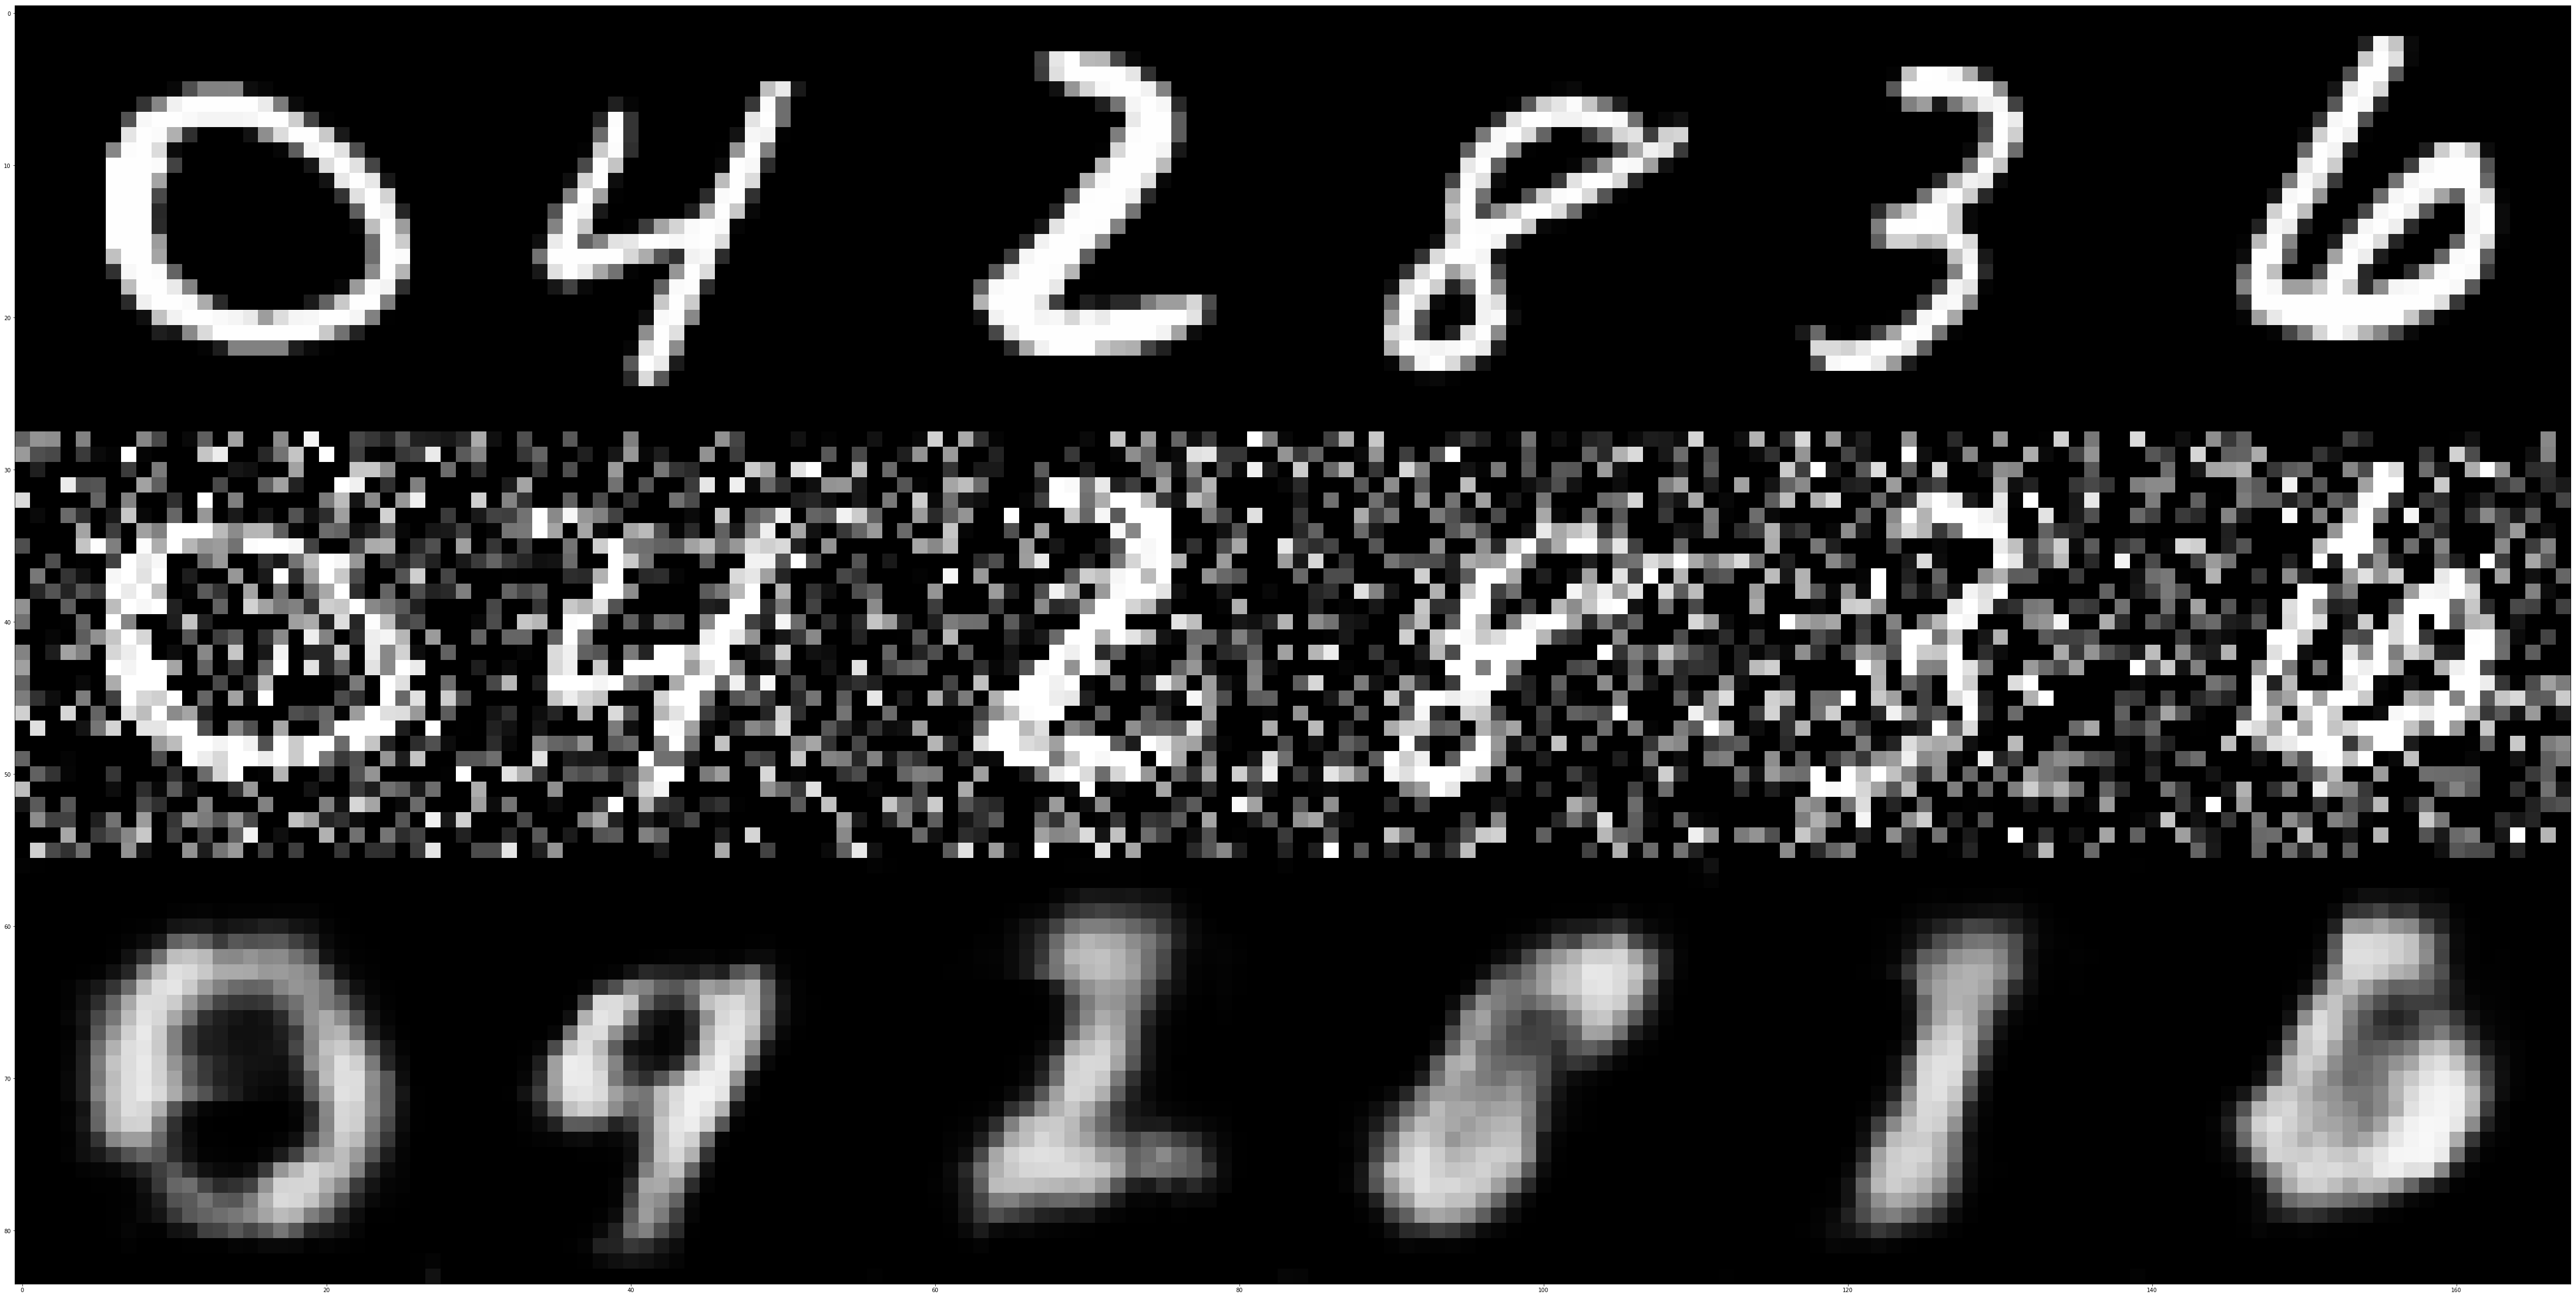

In [11]:
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
#plt.savefig('VAE-Mnist-Gauss.png')
plt.show()

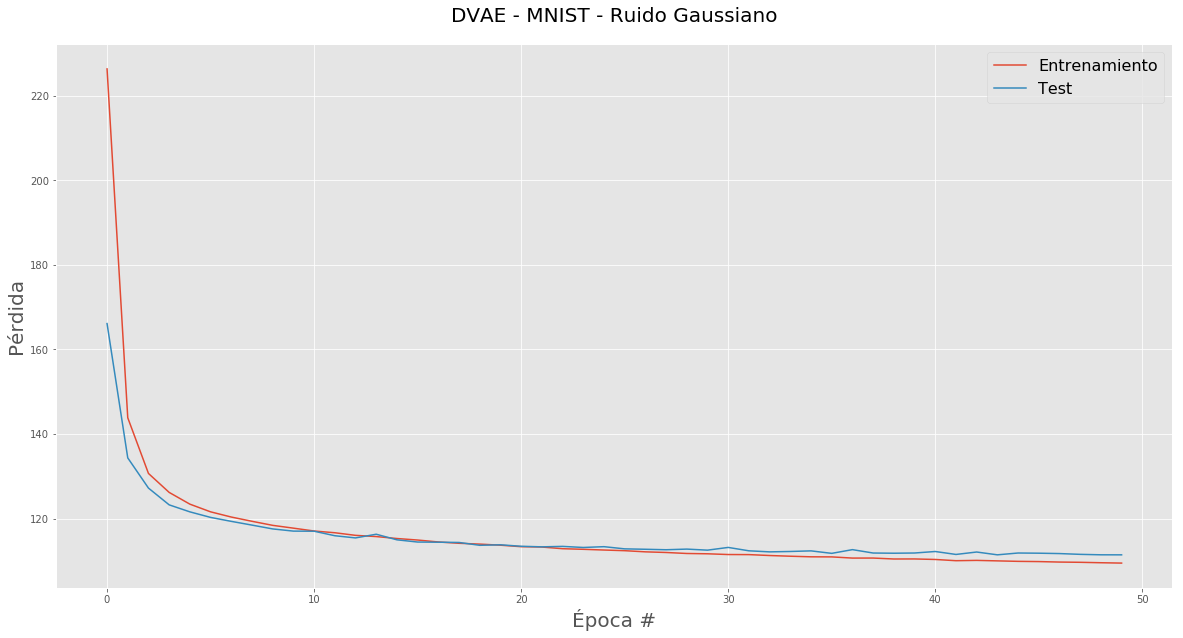

In [6]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - MNIST - Ruido Gaussiano",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Mnist-Gauss-Plot.png')

# Sal y pimienta

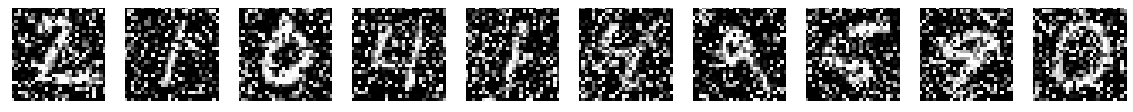

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 26, 26, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [25]:

noise = augmenters.SaltAndPepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test)


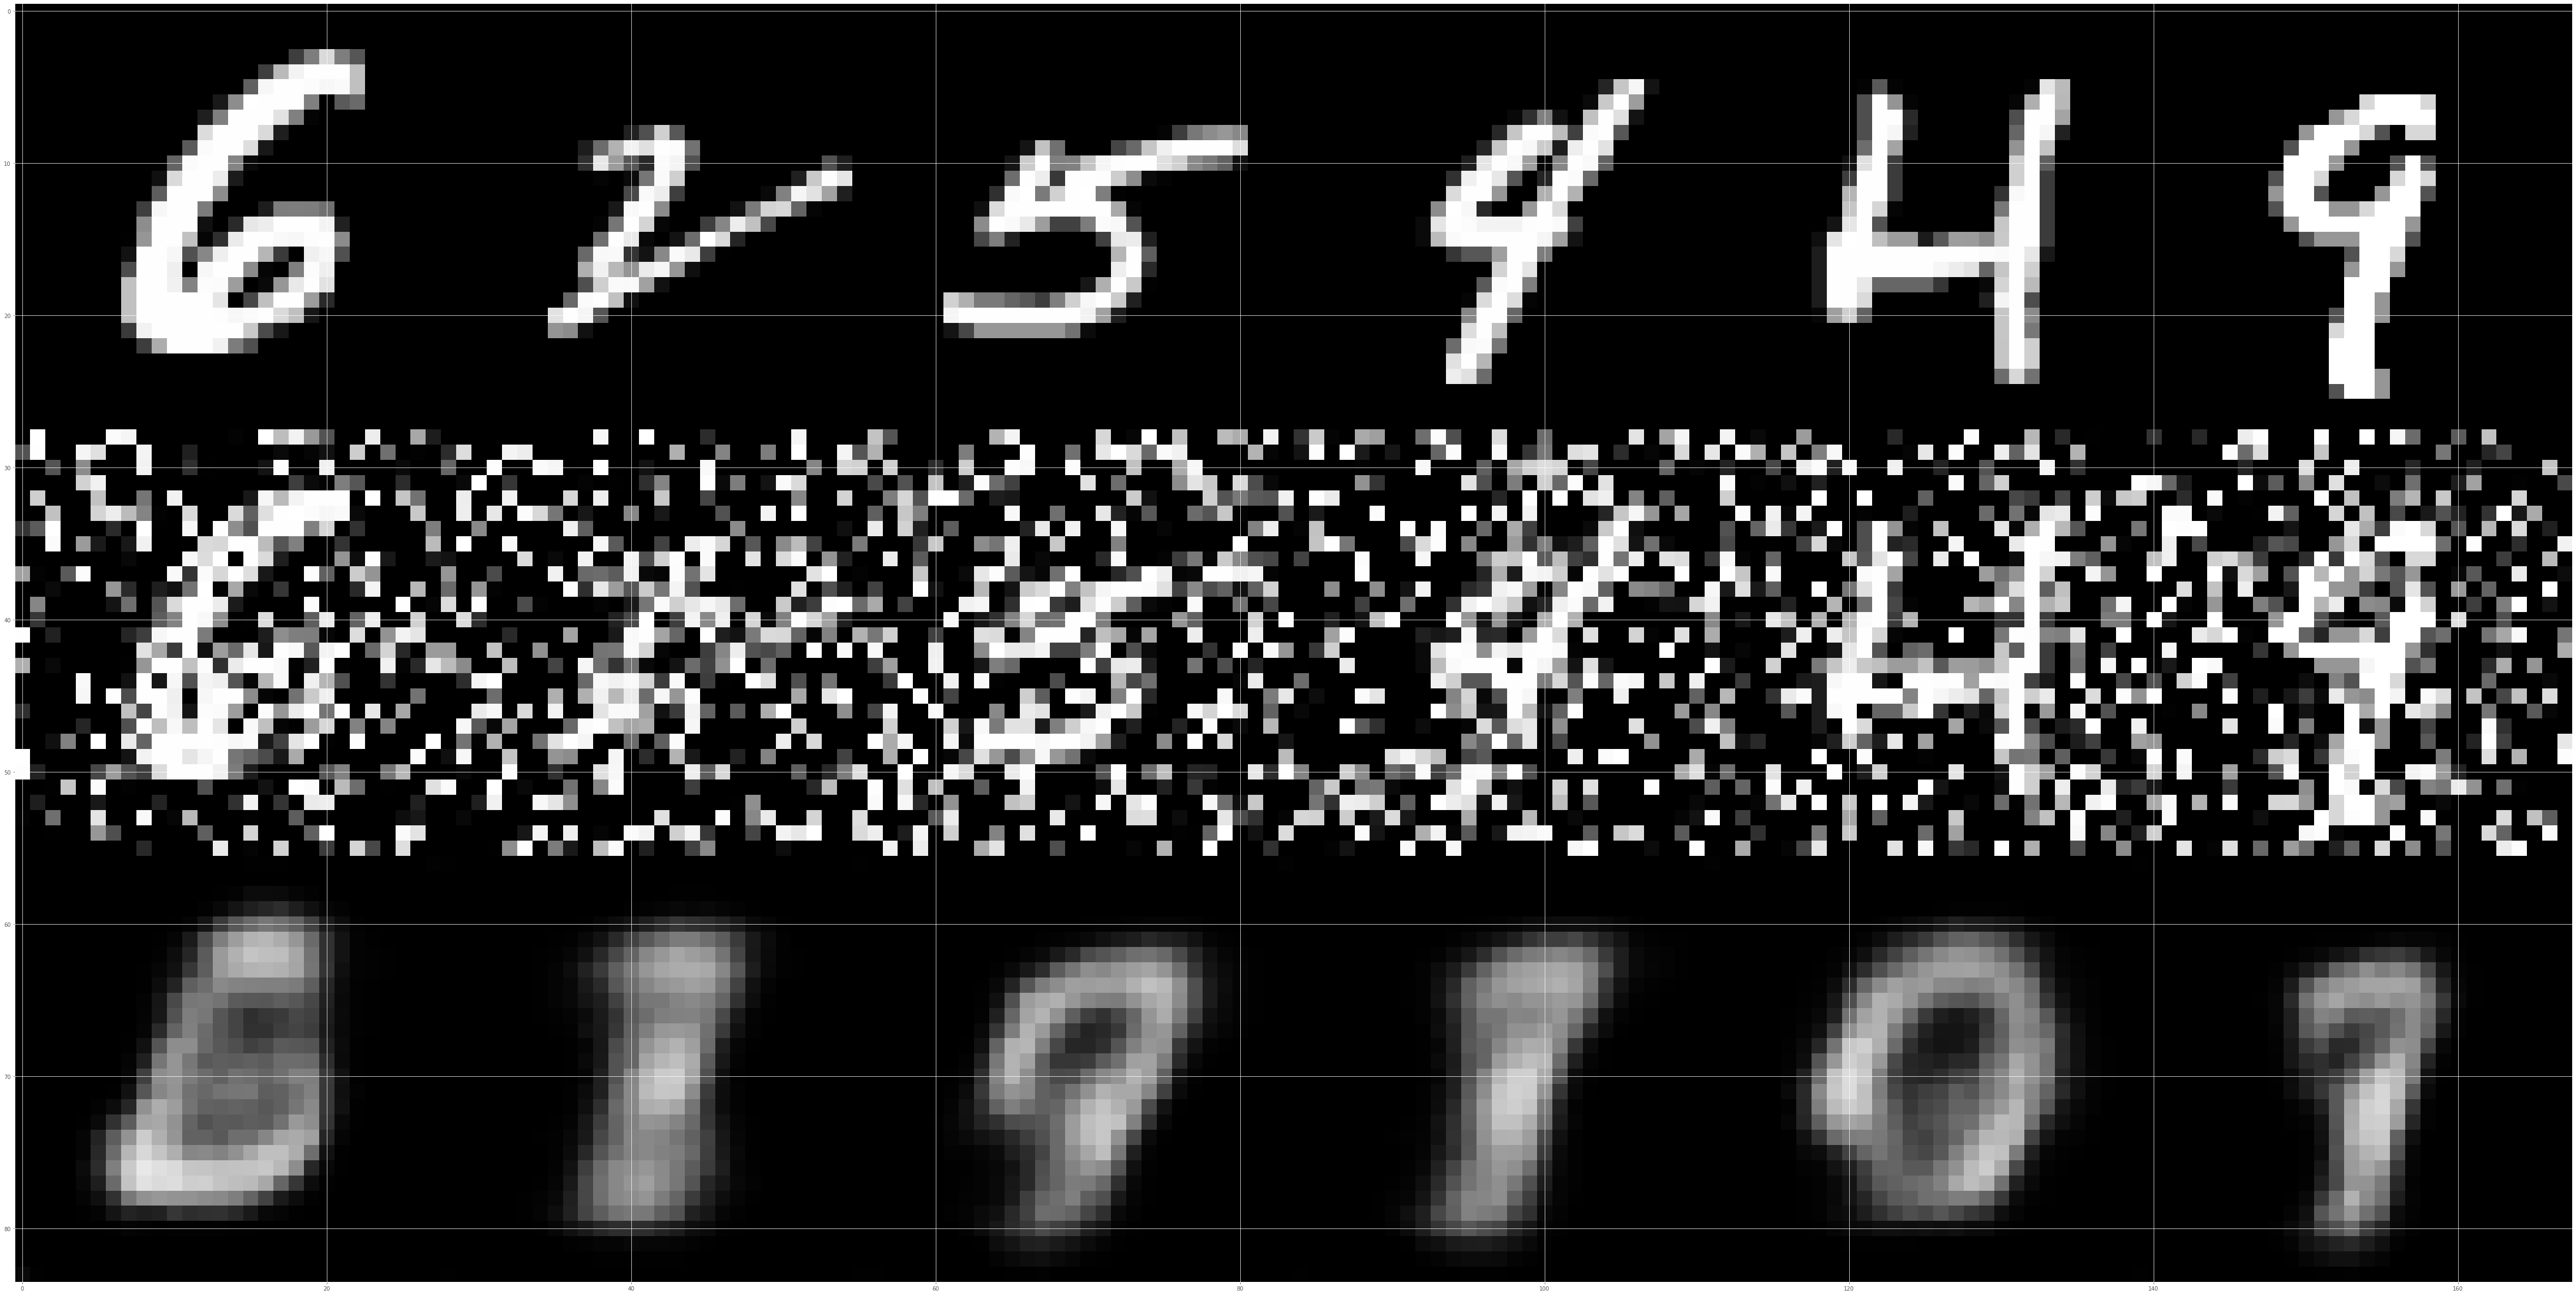

In [26]:
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Mnist-SyP.png')
plt.show()


In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - MNIST - Ruido Sal y Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Mnist-SyP-Plot.png')

## Ruido Sal

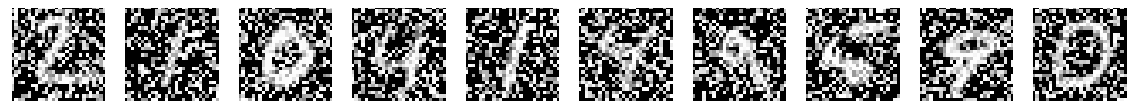

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 26, 26, 64)   640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 

In [27]:
noise = augmenters.Salt(0.4)
seq_object = augmenters.Sequential([noise])
noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test)

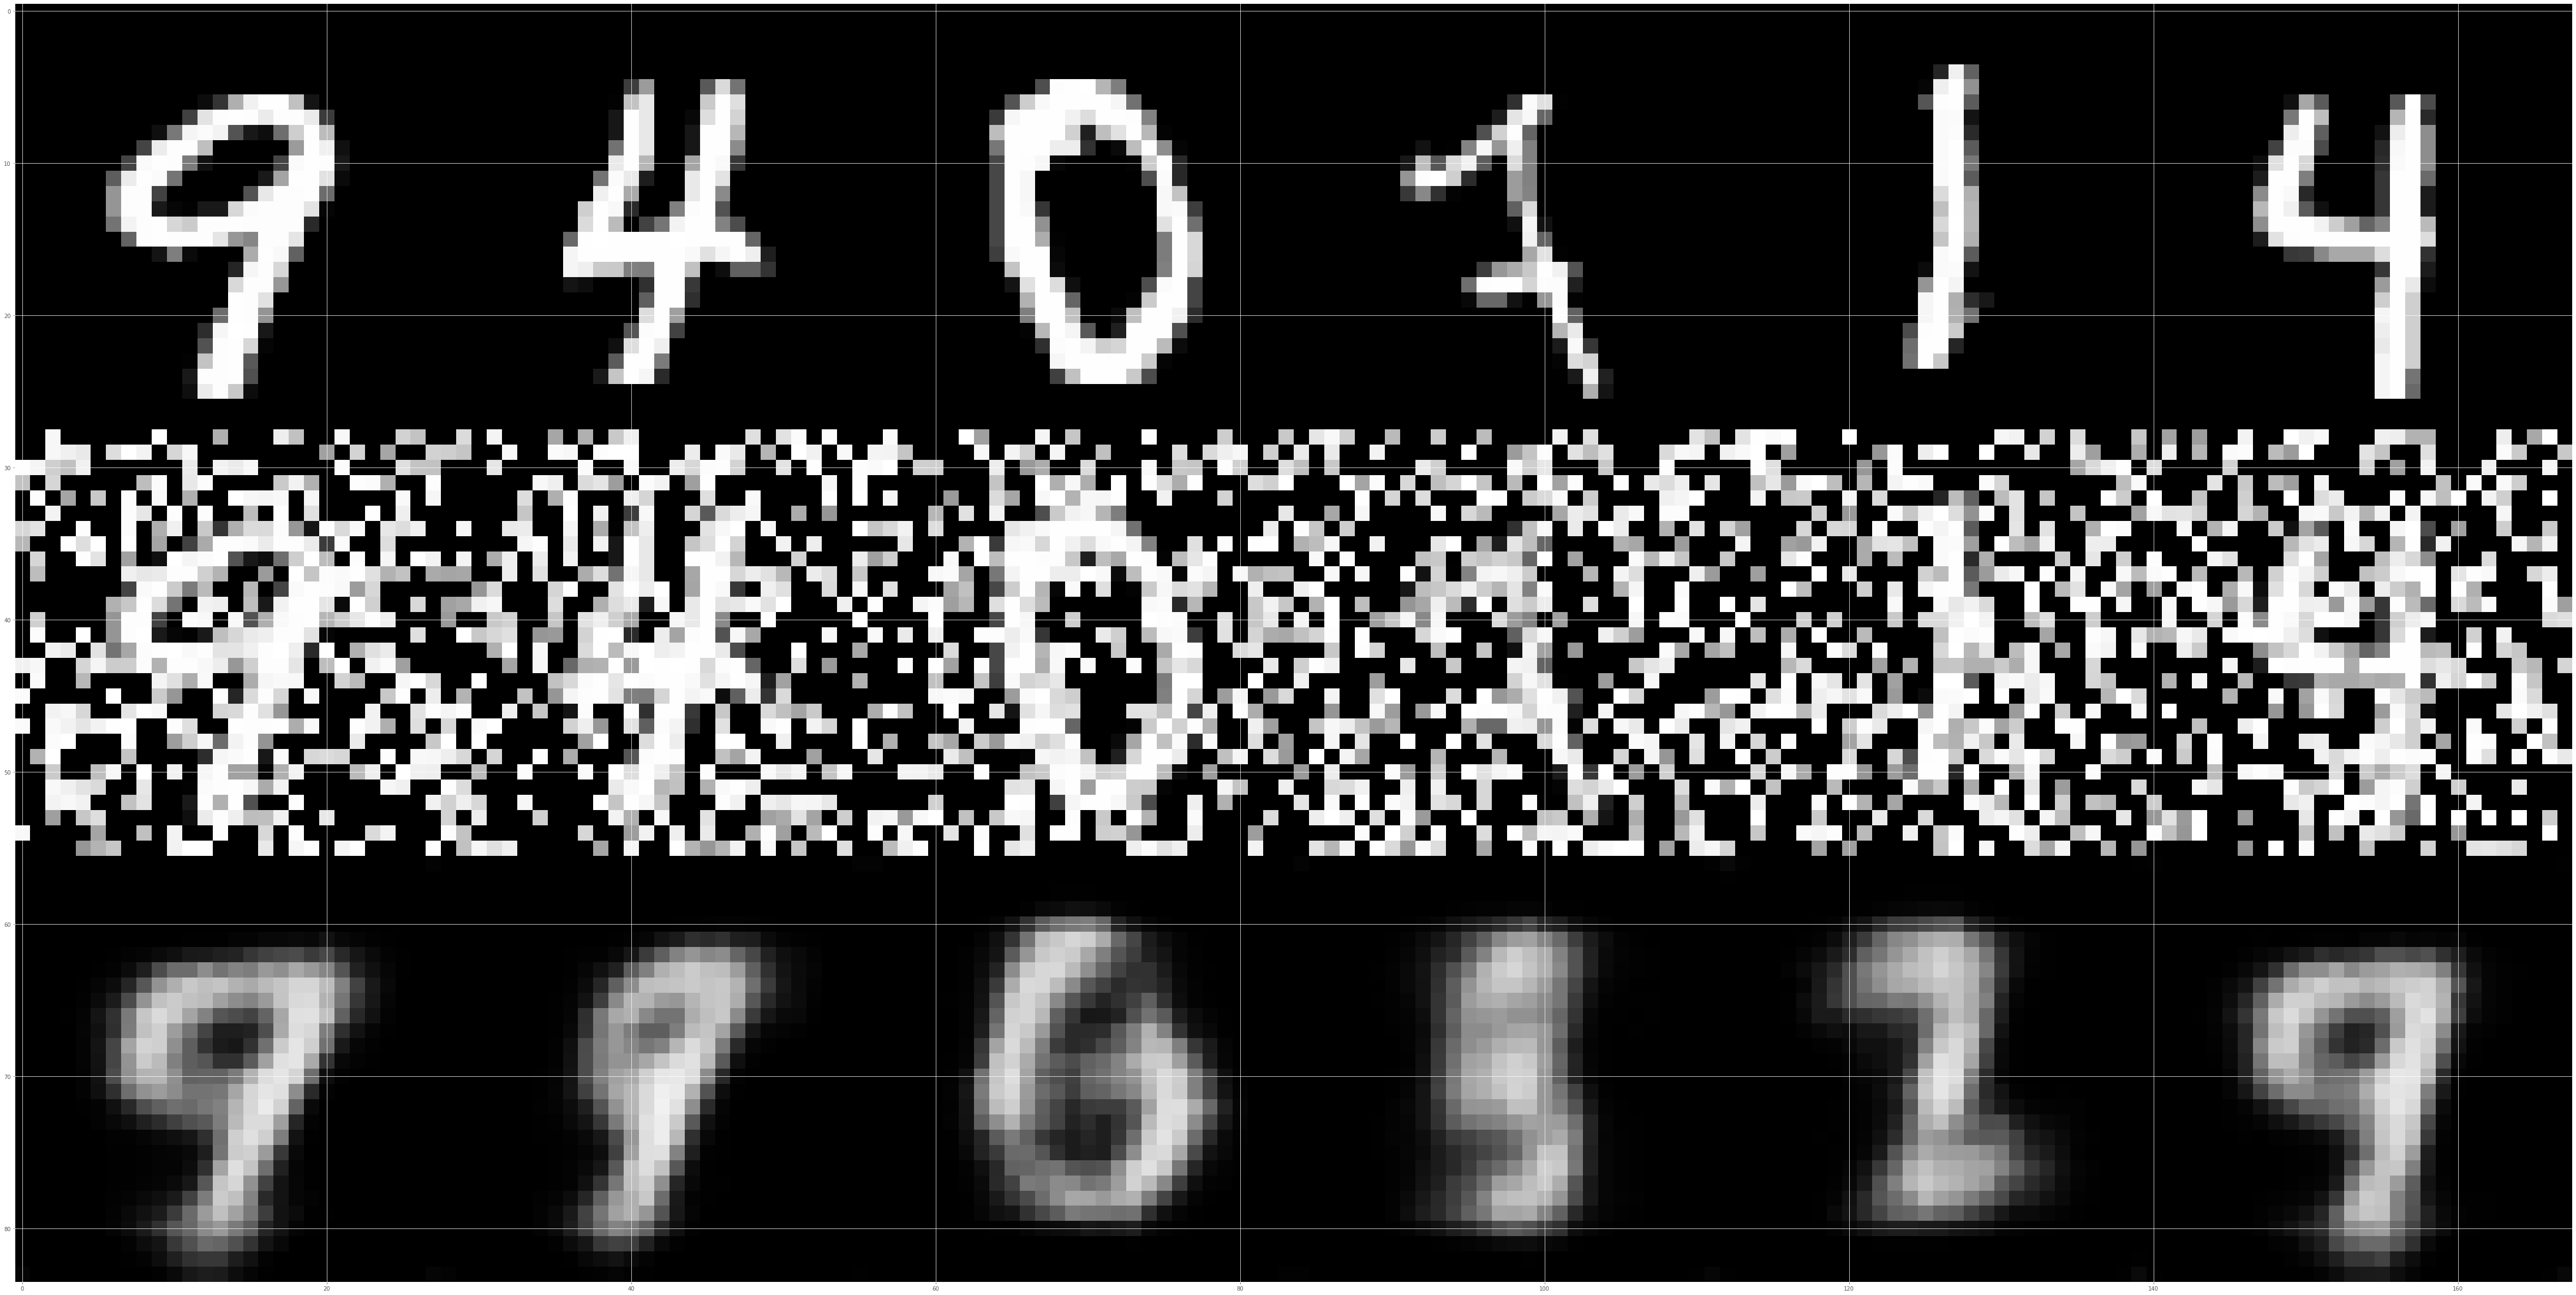

In [28]:
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Mnist-Sal.png')
plt.show()


In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - MNIST - Ruido Sal",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Mnist-Sal-Plot.png')

## Ruido Pimienta

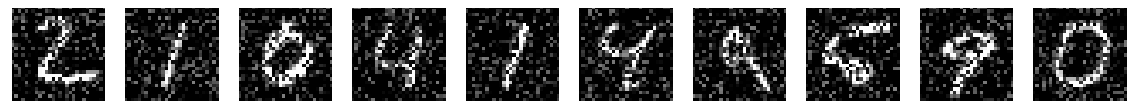

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 26, 26, 64)   640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 12, 12, 64)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

In [29]:
noise = augmenters.Pepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test)

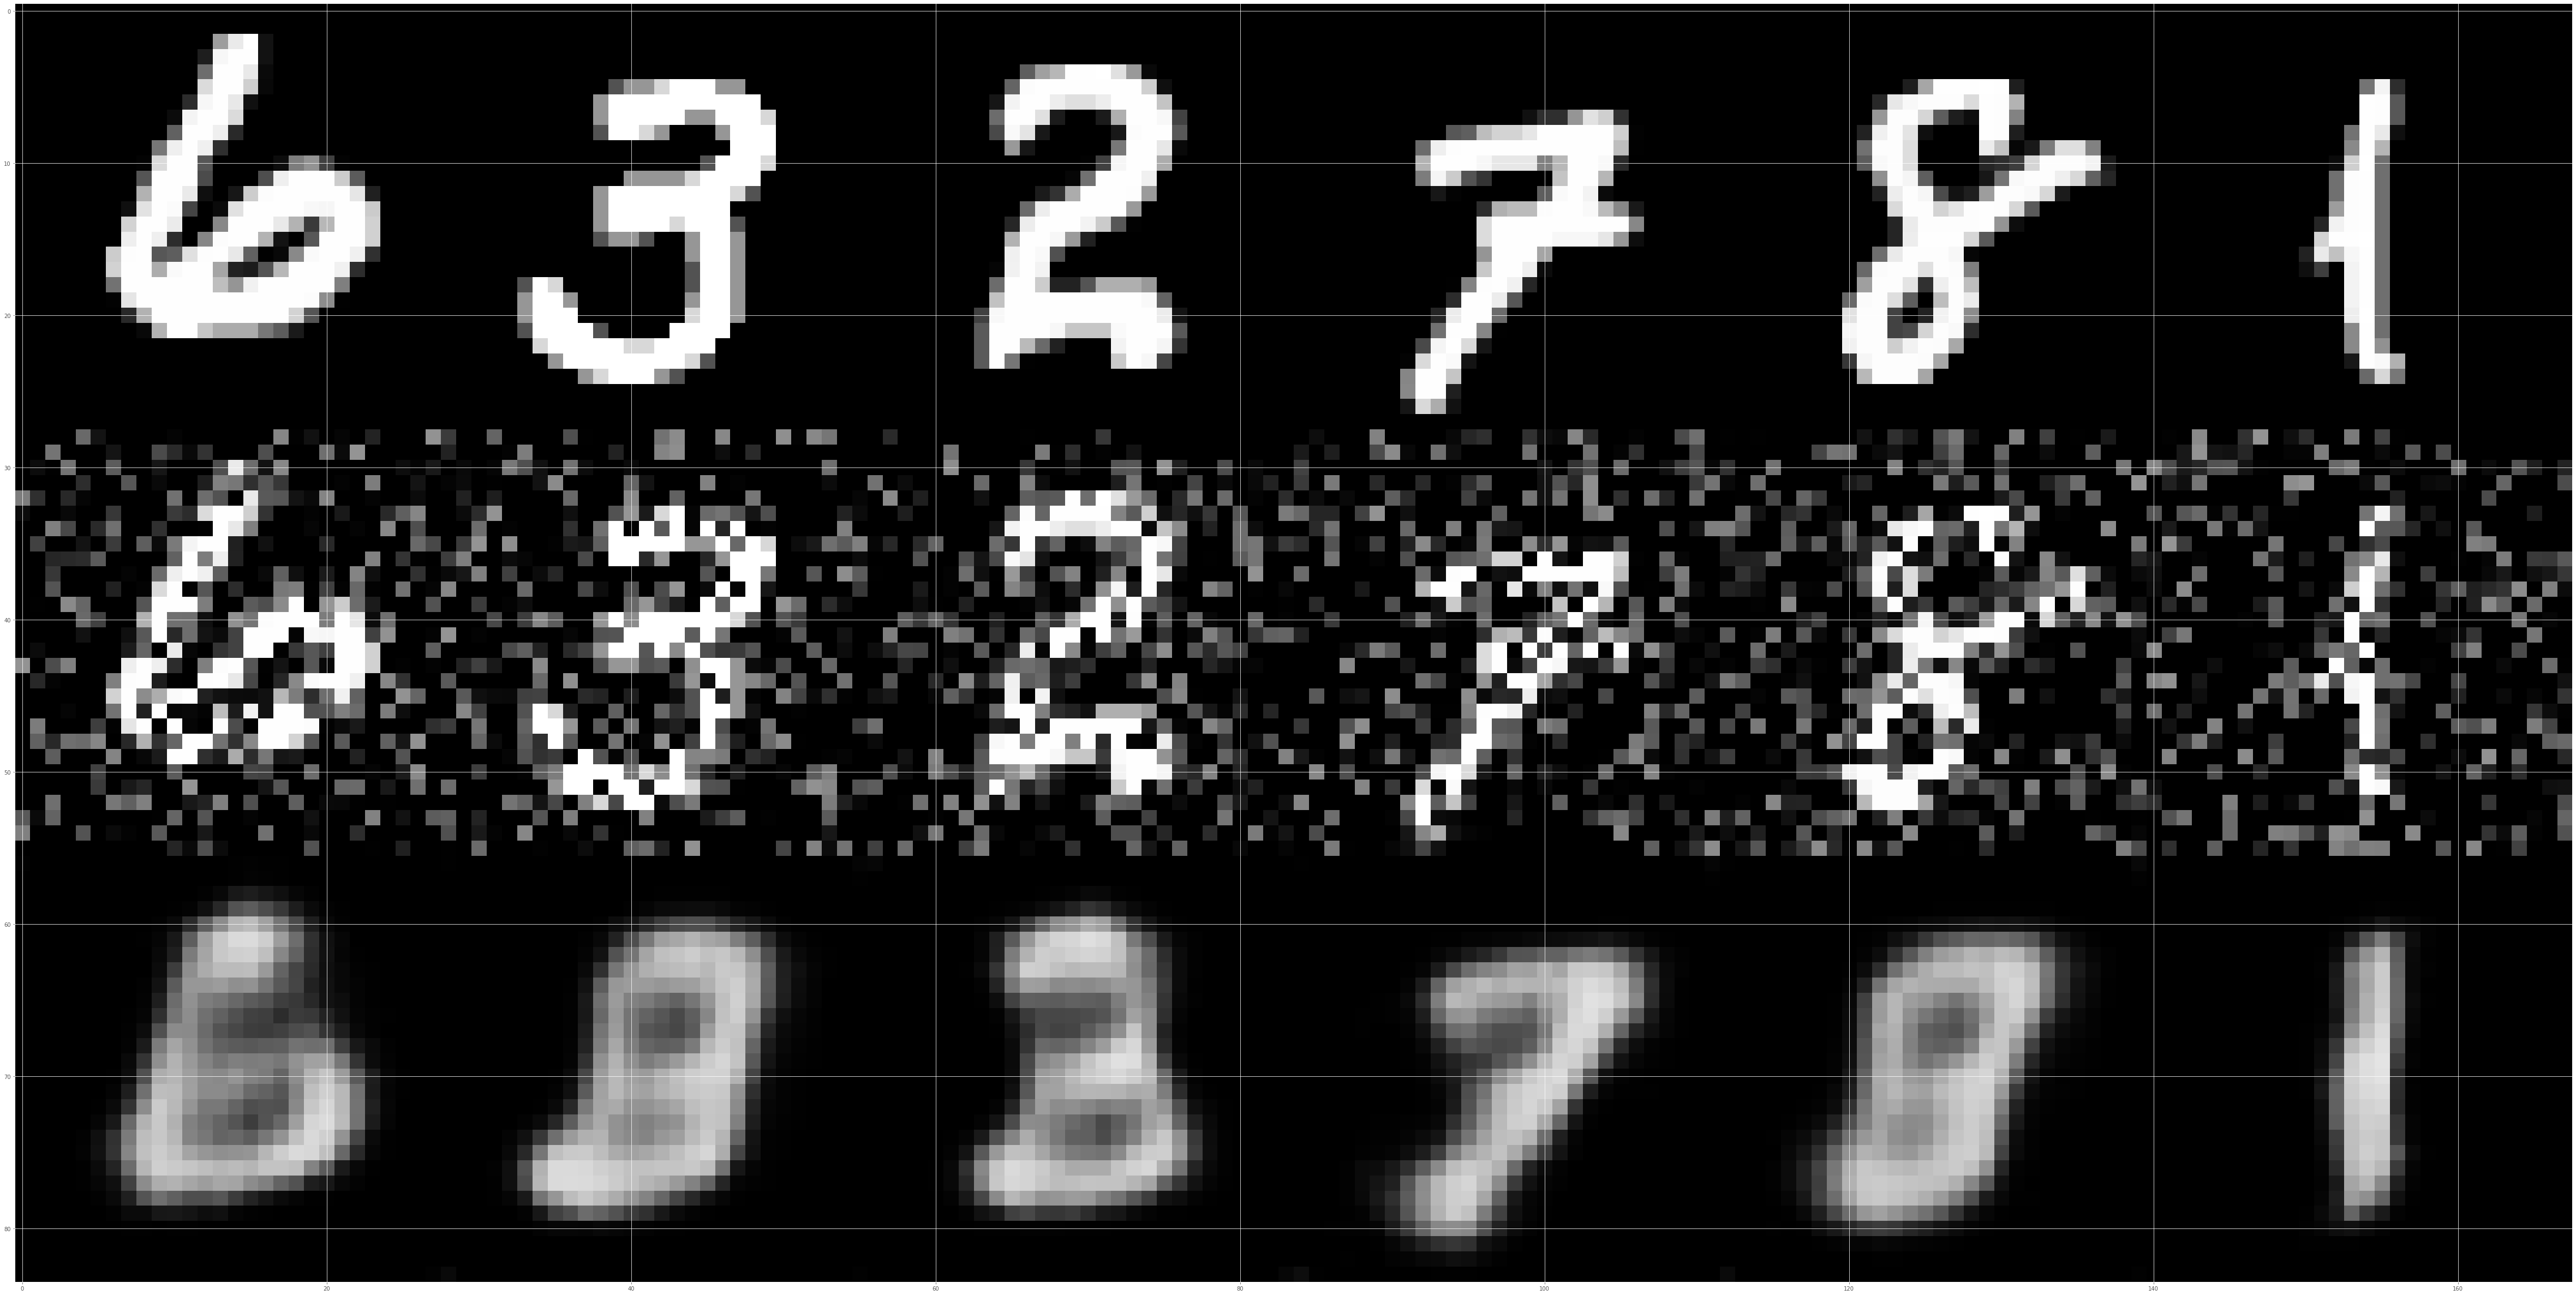

In [30]:
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Mnist-Pim.png')
plt.show()


In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - MNIST - Ruido Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Mnist-Pim-Plot.png')

# Fashion Mnist

## Ruido Gaussiano

In [7]:
#Inicialización de los datos.
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))

In [4]:
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])

W0630 15:25:35.544818 139909065643776 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 15:25:35.610035 139909065643776 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 15:25:35.639300 139909065643776 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 15:25:35.690508 139909065643776 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 423s 7ms/step - loss: 336.5574 - val_loss: 275.9349
Epoch 2/50
60000/60000 [==============================] - 426s 7ms/step - loss: 268.4439 - val_loss: 269.2136
Epoch 3/50
60000/60000 [==============================] - 445s 7ms/step - loss: 261.9508 - val_loss: 261.8471
Epoch 4/50
60000/60000 [==============================] - 416s 7ms/step - loss: 258.8167 - val_loss: 259.2703
Epoch 5/50
60000/60000 [==============================] - 429s 7ms/step - loss: 256.7169 - val_loss: 257.9452
Epoch 6/50
60000/60000 [==============================] - 437s 7ms/step - loss: 255.4131 - val_loss: 257.7000
Epoch 7/50
60000/60000 [==============================] - 406s 7ms/step - loss: 254.6599 - val_loss: 255.6212
Epoch 8/50
60000/60000 [==============================] - 364s 6ms/step - loss: 253.5089 - val_loss: 254.6400
Epoch 9/50
60000/60000 [==============================] - 316s 5ms/ste

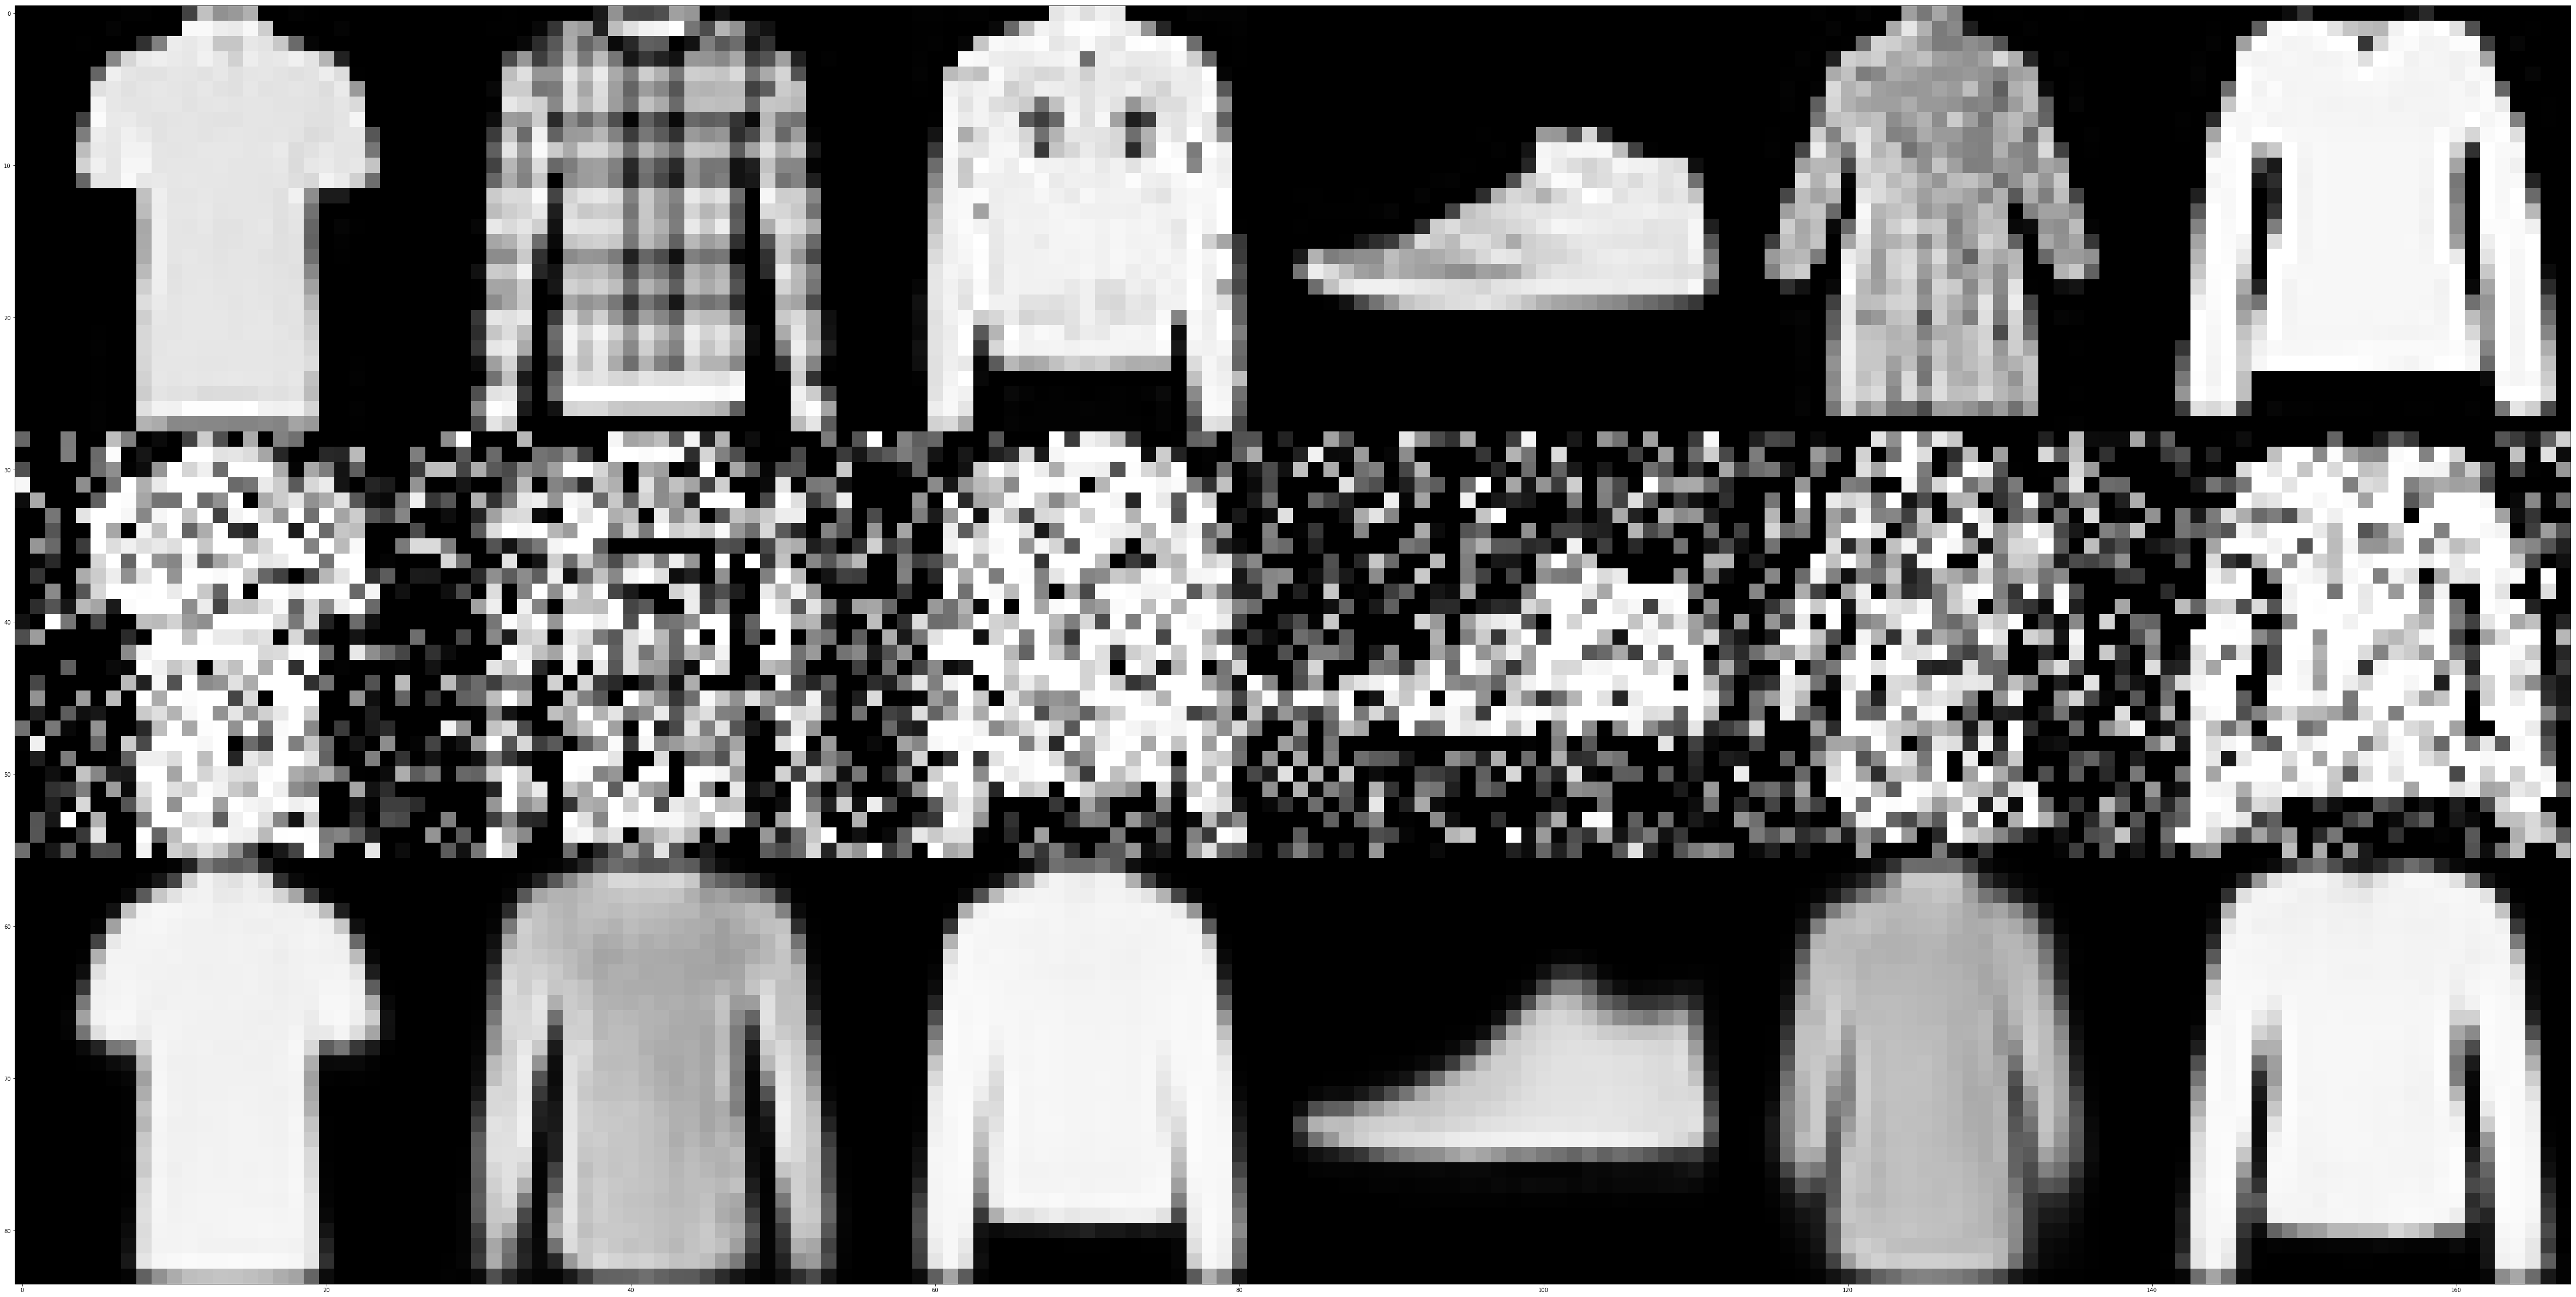

In [5]:
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Fash-Gauss.png')
plt.show()

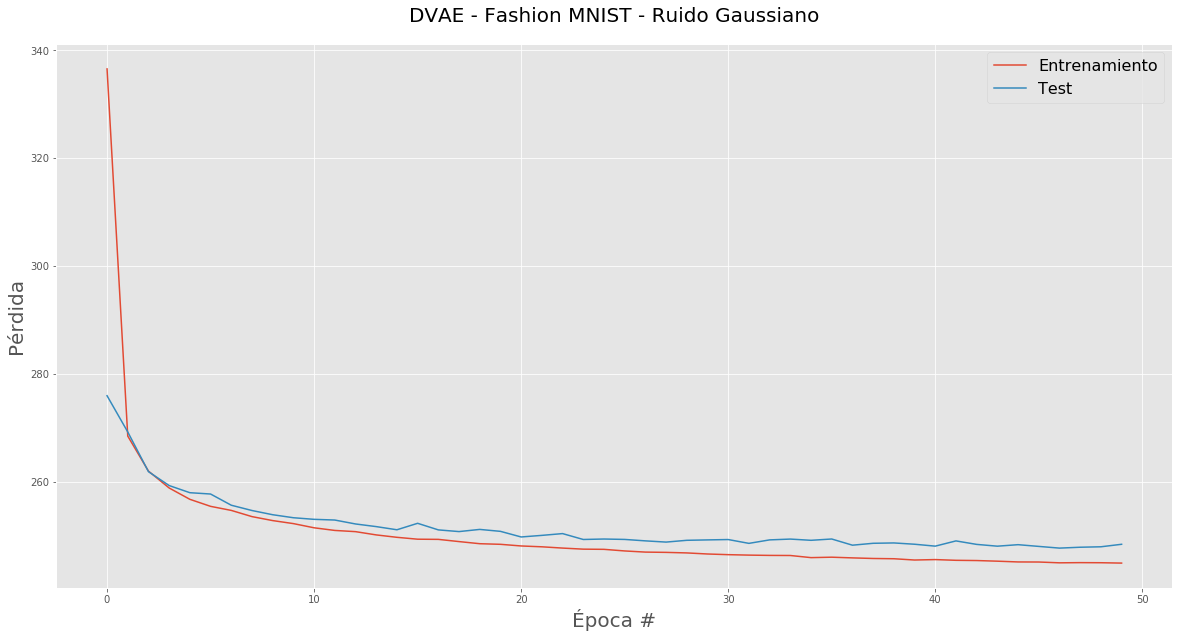

In [6]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Fashion MNIST - Ruido Gaussiano",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Fash-Gauss-Plot.png')

## Ruido Sal y pimienta

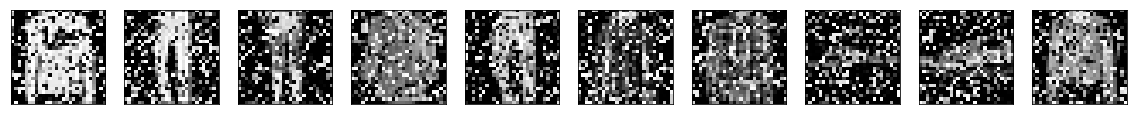

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 318s 5ms/step - loss: 339.5782 - val_loss: 278.2989
Epoch 2/50
60000/60000 [==============================] - 312s 5ms/step - loss: 269.8527 - val_loss: 268.0888
Epoch 3/50
60000/60000 [==============================] - 312s 5ms/step - loss: 262.5615 - val_loss: 262.9933
Epoch 4/50
60000/60000 [==============================] - 311s 5ms/step - loss: 258.7748 - val_loss: 261.1008
Epoch 5/50
60000/60000 [==============================] - 324s 5ms/step - loss: 256.7499 - val_loss: 256.9434
Epoch 6/50
60000/60000 [==============================] - 343s 6ms/step - loss: 255.0508 - val_loss: 255.7550
Epoch 7/50
60000/60000 [==============================] - 327s 5ms/step - loss: 254.0318 - val_loss: 255.2241
Epoch 8/50
60000/60000 [==============================] - 339s 6ms/step - loss: 253.1027 - val_loss: 253.9083
Epoch 9/50
60000/60000 [==============================] - 317s 5ms/ste

In [8]:
noise = augmenters.SaltAndPepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test)

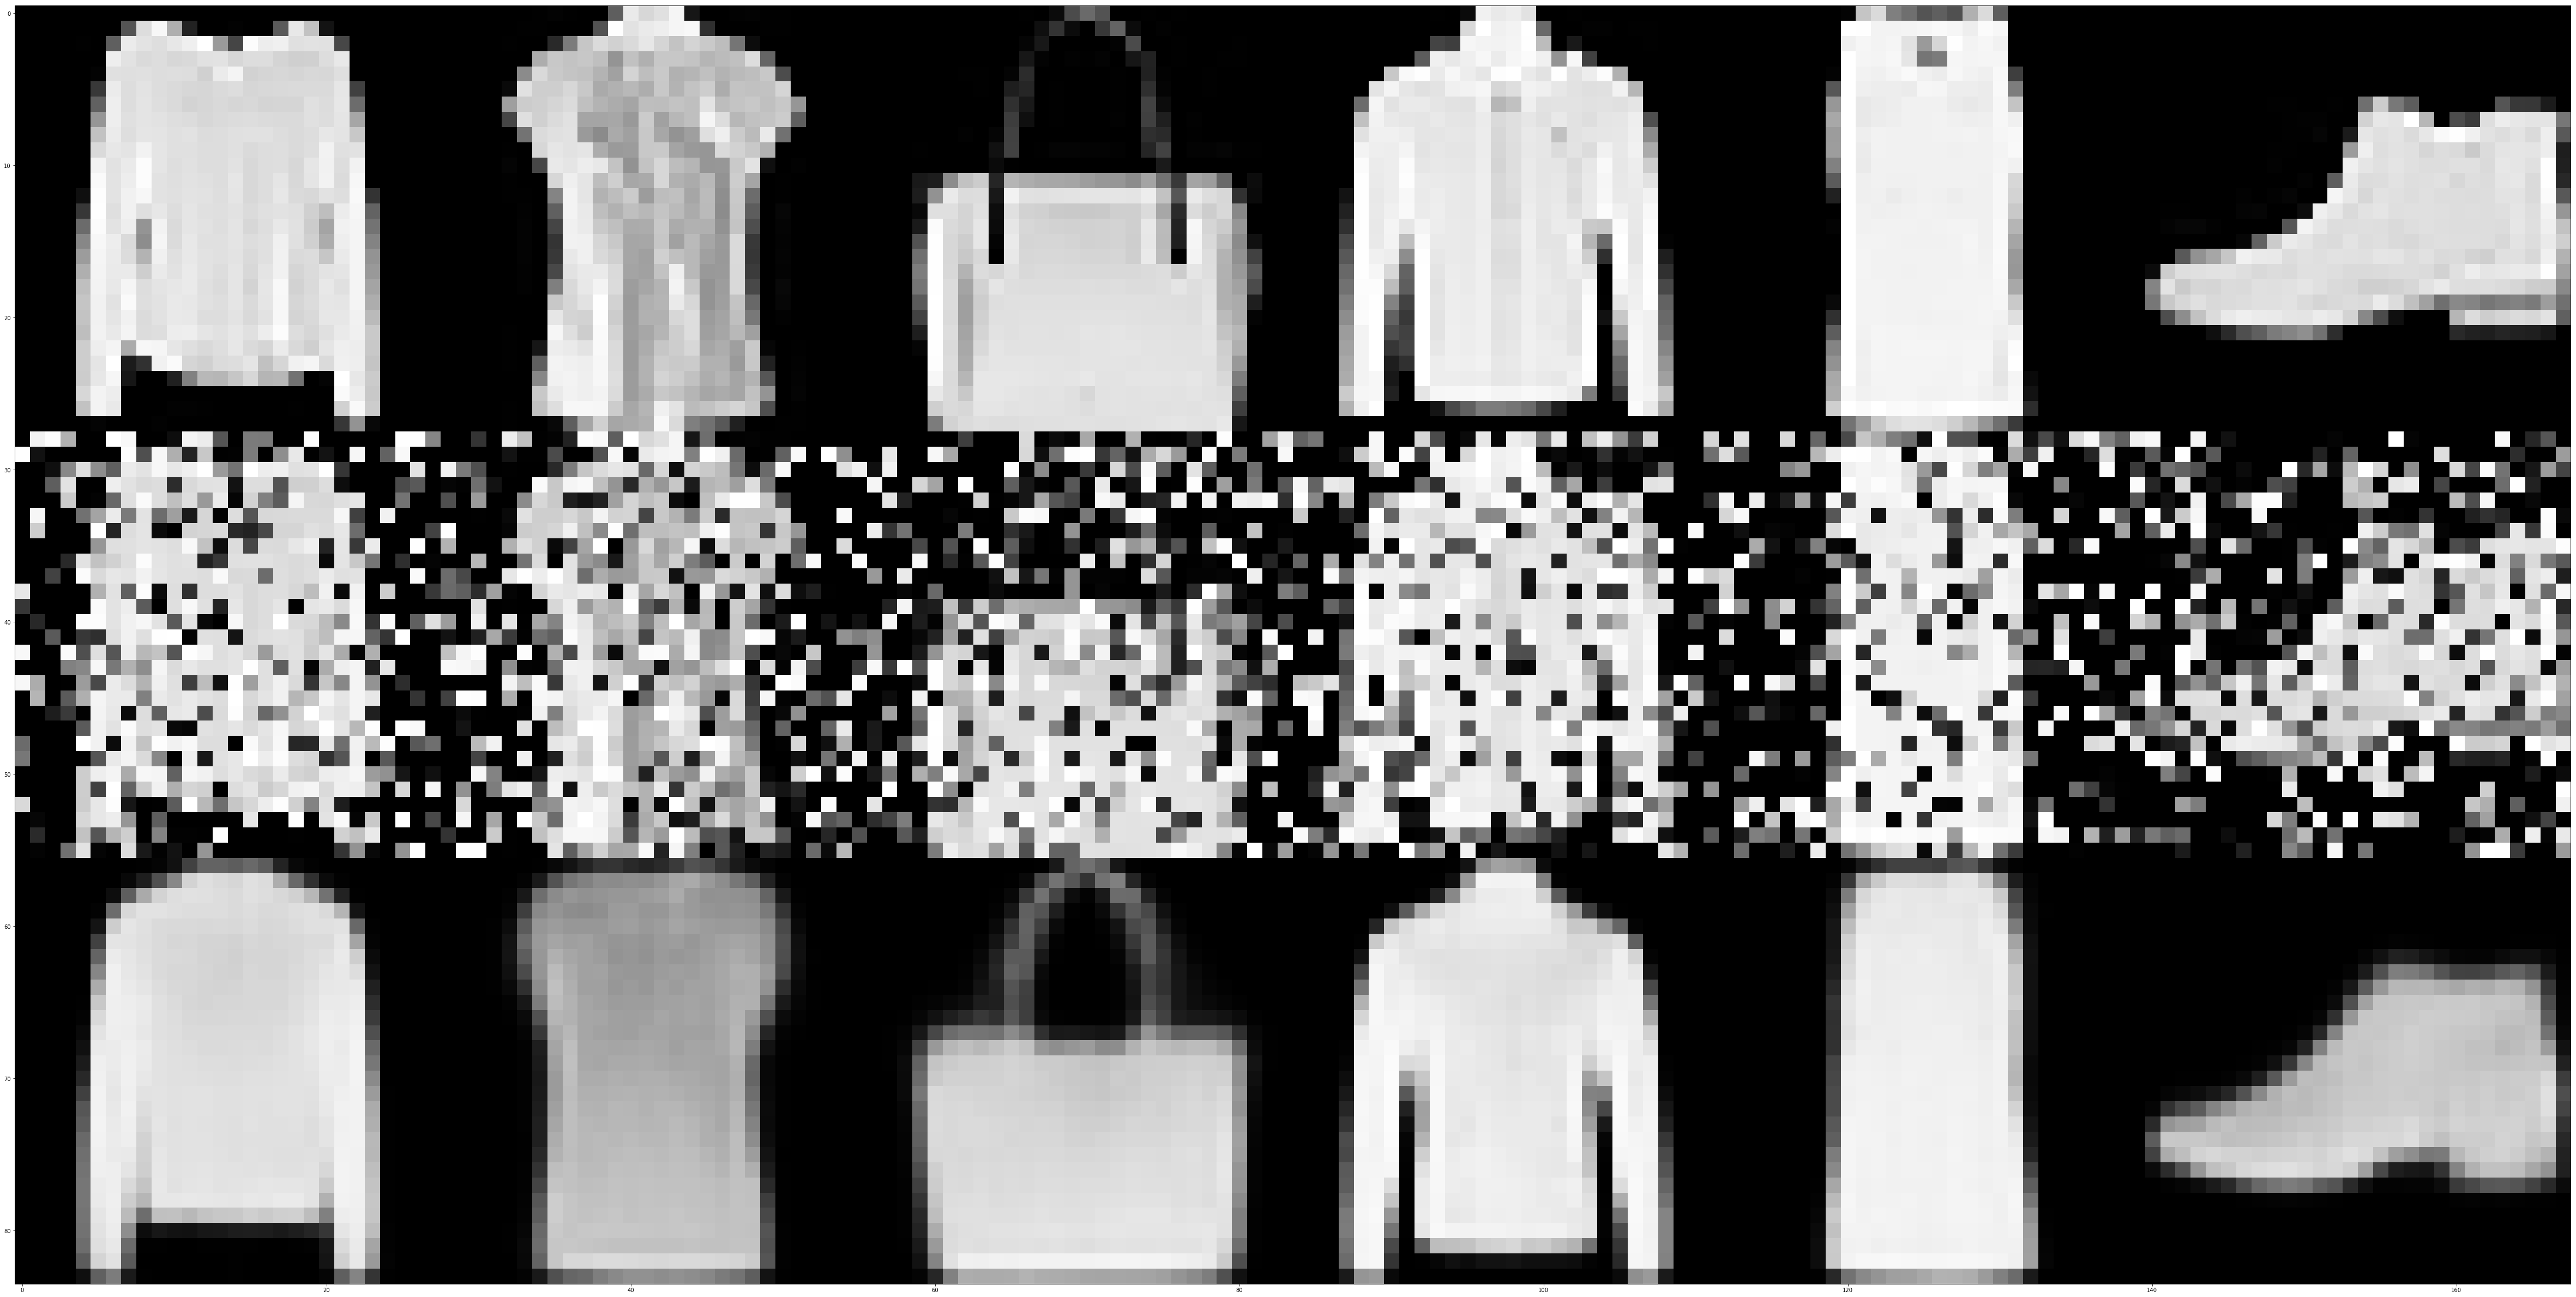

In [9]:
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Fash-SyP.png')
plt.show()

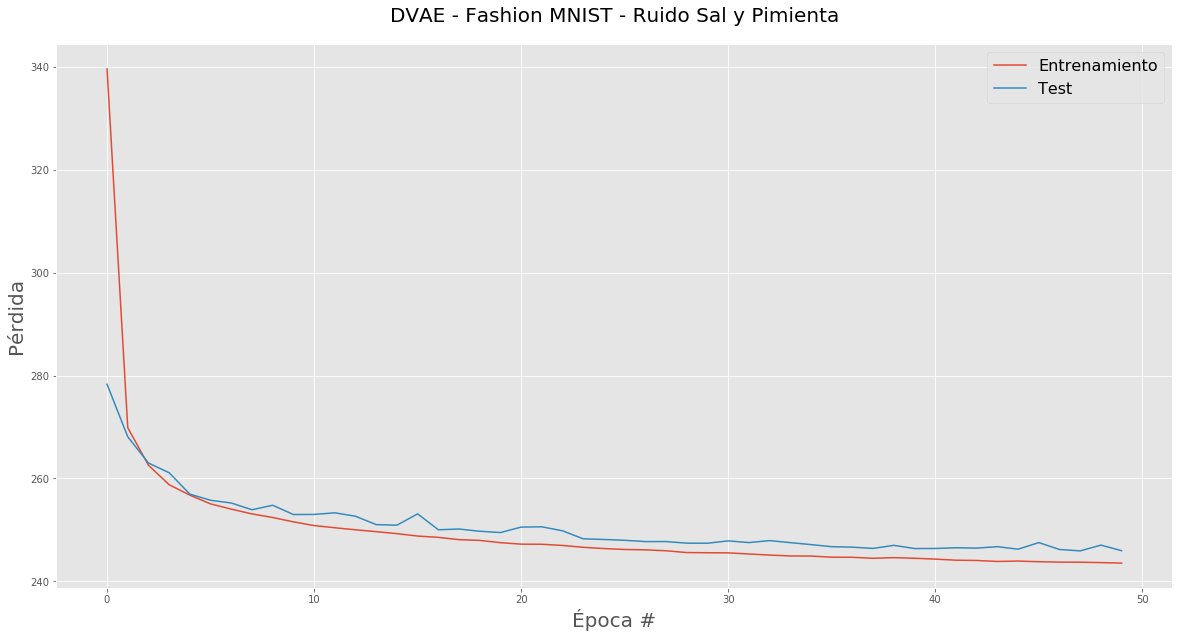

In [10]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Fashion MNIST - Ruido Sal y Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Fash-SyP-Plot.png')

## Ruido Sal

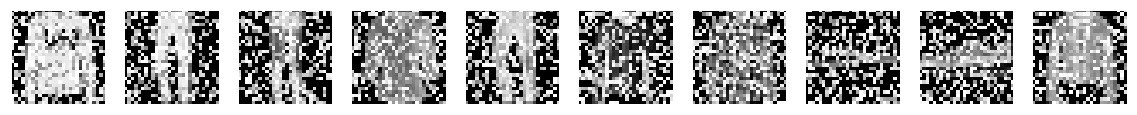

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 337s 6ms/step - loss: 334.6237 - val_loss: 274.8521
Epoch 2/50
60000/60000 [==============================] - 347s 6ms/step - loss: 267.2660 - val_loss: 269.3814
Epoch 3/50
60000/60000 [==============================] - 364s 6ms/step - loss: 260.4996 - val_loss: 259.8879
Epoch 4/50
60000/60000 [==============================] - 347s 6ms/step - loss: 257.0430 - val_loss: 257.5498
Epoch 5/50
60000/60000 [==============================] - 352s 6ms/step - loss: 254.8573 - val_loss: 256.9197
Epoch 6/50
60000/60000 [==============================] - 362s 6ms/step - loss: 253.2355 - val_loss: 254.3446
Epoch 7/50
60000/60000 [==============================] - 335s 6ms/step - loss: 251.8829 - val_loss: 253.0476
Epoch 8/50
60000/60000 [==============================] - 327s 5ms/step - loss: 250.7936 - val_loss: 252.1082
Epoch 9/50
60000/60000 [==============================] - 329s 5ms/ste

In [11]:
noise = augmenters.Salt(0.4)
seq_object = augmenters.Sequential([noise])
noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)


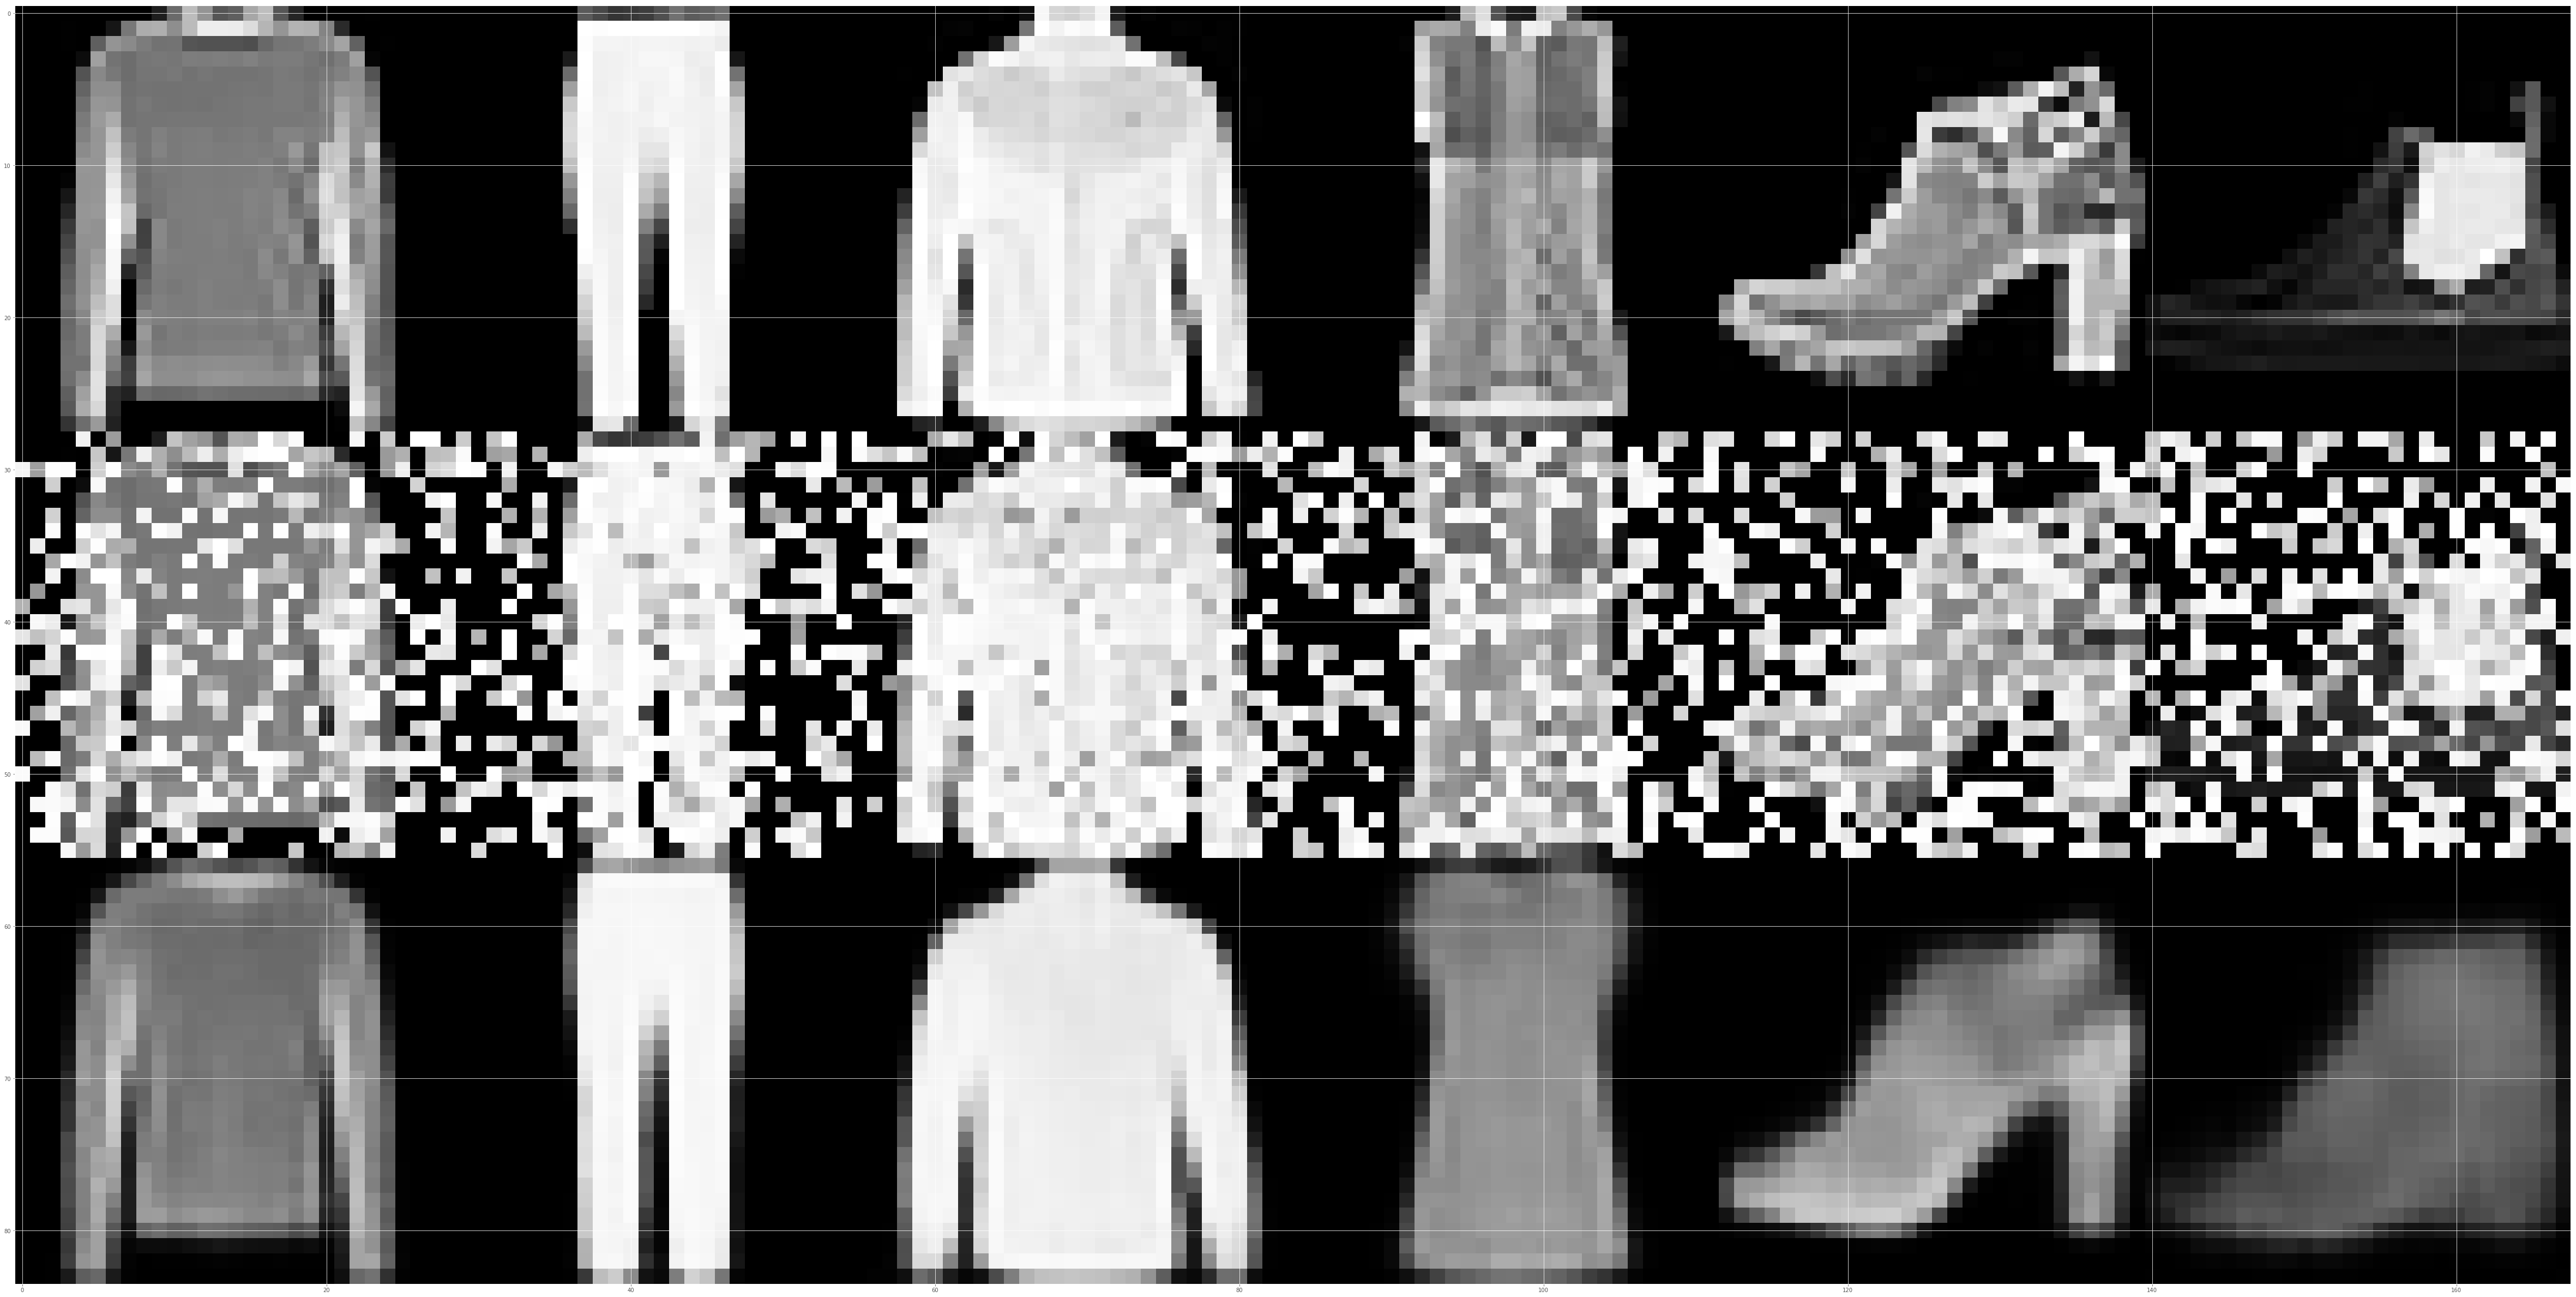

In [12]:
x_out=vae.predict(x_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Fash-Sal.png')
plt.show()

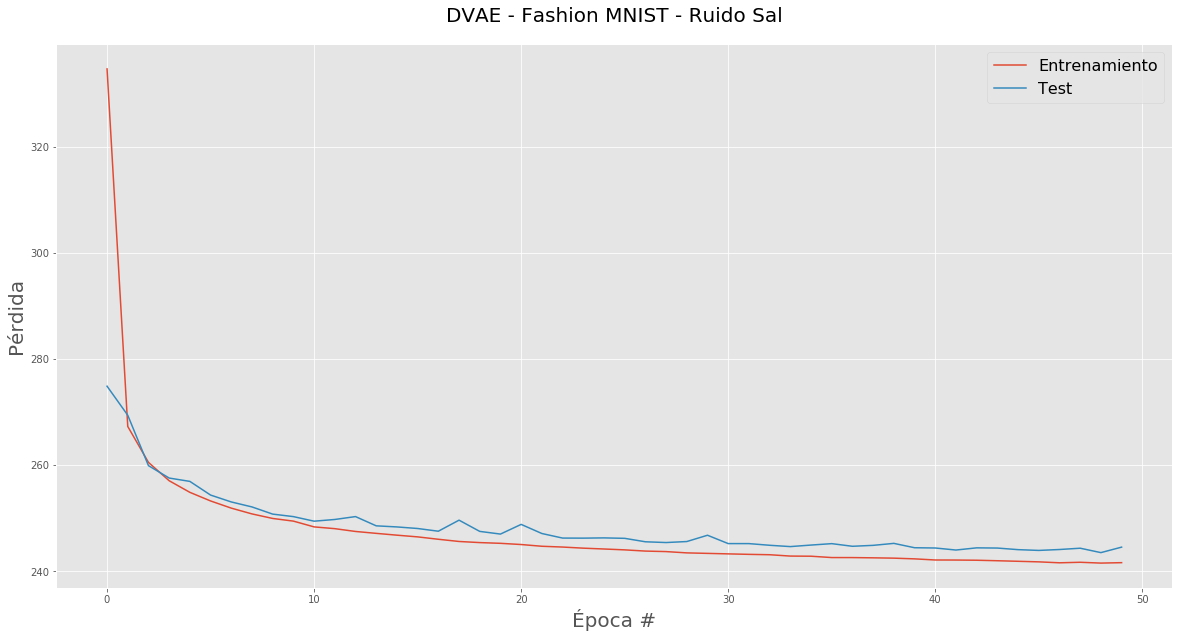

In [13]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Fashion MNIST - Ruido Sal",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Fash-Sal-Plot.png')

## Ruido Pimienta

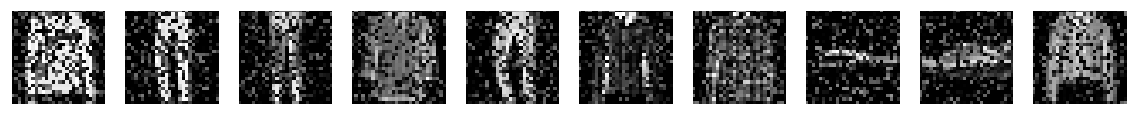

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 401s 7ms/step - loss: 333.7040 - val_loss: 273.4223
Epoch 2/50
60000/60000 [==============================] - 369s 6ms/step - loss: 266.7583 - val_loss: 265.1808
Epoch 3/50
60000/60000 [==============================] - 379s 6ms/step - loss: 260.0941 - val_loss: 261.5981
Epoch 4/50
60000/60000 [==============================] - 340s 6ms/step - loss: 256.9159 - val_loss: 257.1447
Epoch 5/50
60000/60000 [==============================] - 316s 5ms/step - loss: 254.8803 - val_loss: 256.3897
Epoch 6/50
60000/60000 [==============================] - 390s 6ms/step - loss: 253.2745 - val_loss: 254.5793
Epoch 7/50
60000/60000 [==============================] - 345s 6ms/step - loss: 252.0480 - val_loss: 253.4640
Epoch 8/50
60000/60000 [==============================] - 349s 6ms/step - loss: 251.0415 - val_loss: 252.2732
Epoch 9/50
60000/60000 [==============================] - 474s 8ms/ste

In [14]:
noise = augmenters.Pepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=VAE_loss)


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])

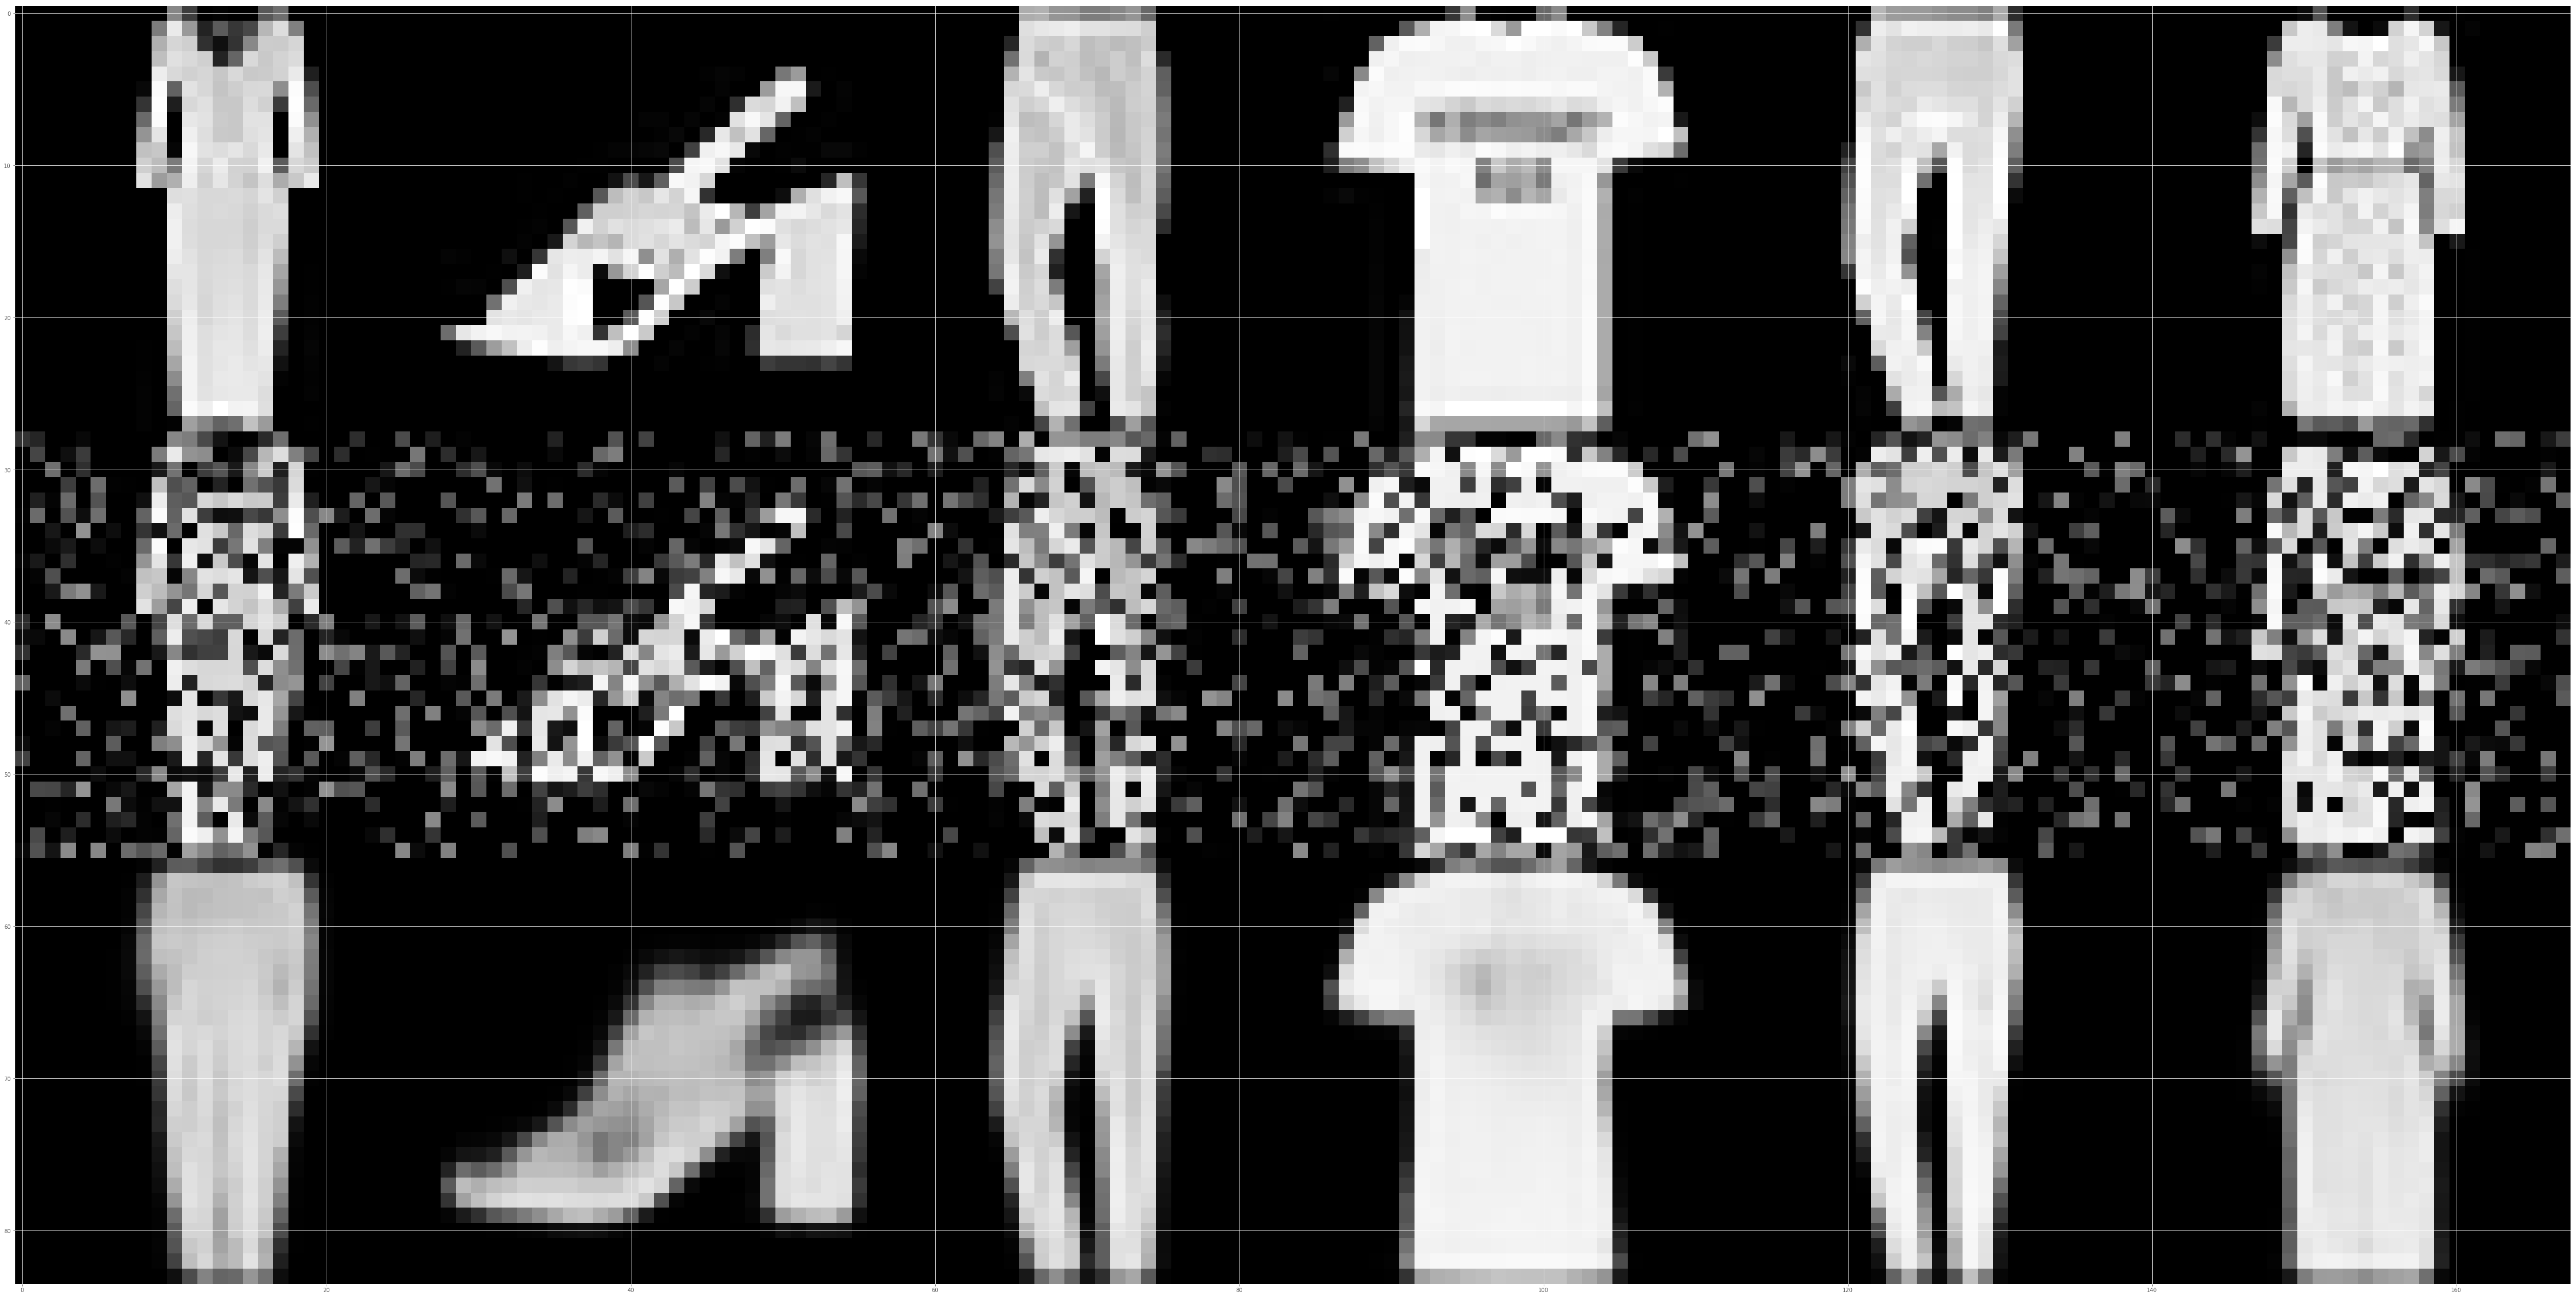

In [20]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[idx], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Fash-Pim.png')
plt.show()

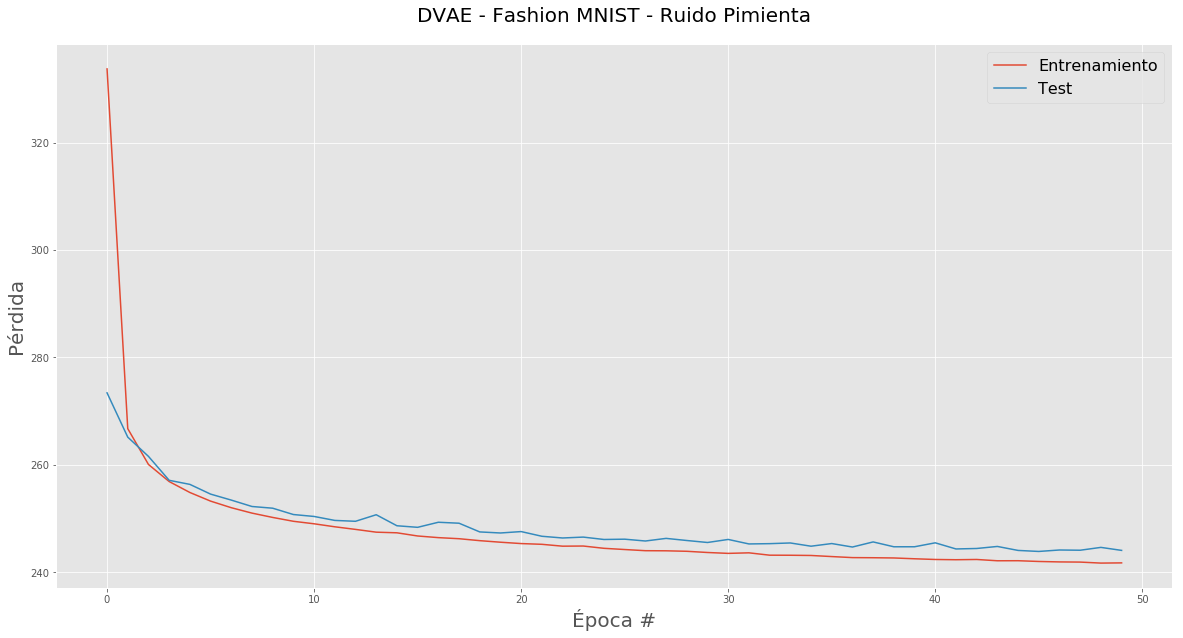

In [16]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Fashion MNIST - Ruido Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE-Fash-Pim-Plot.png')

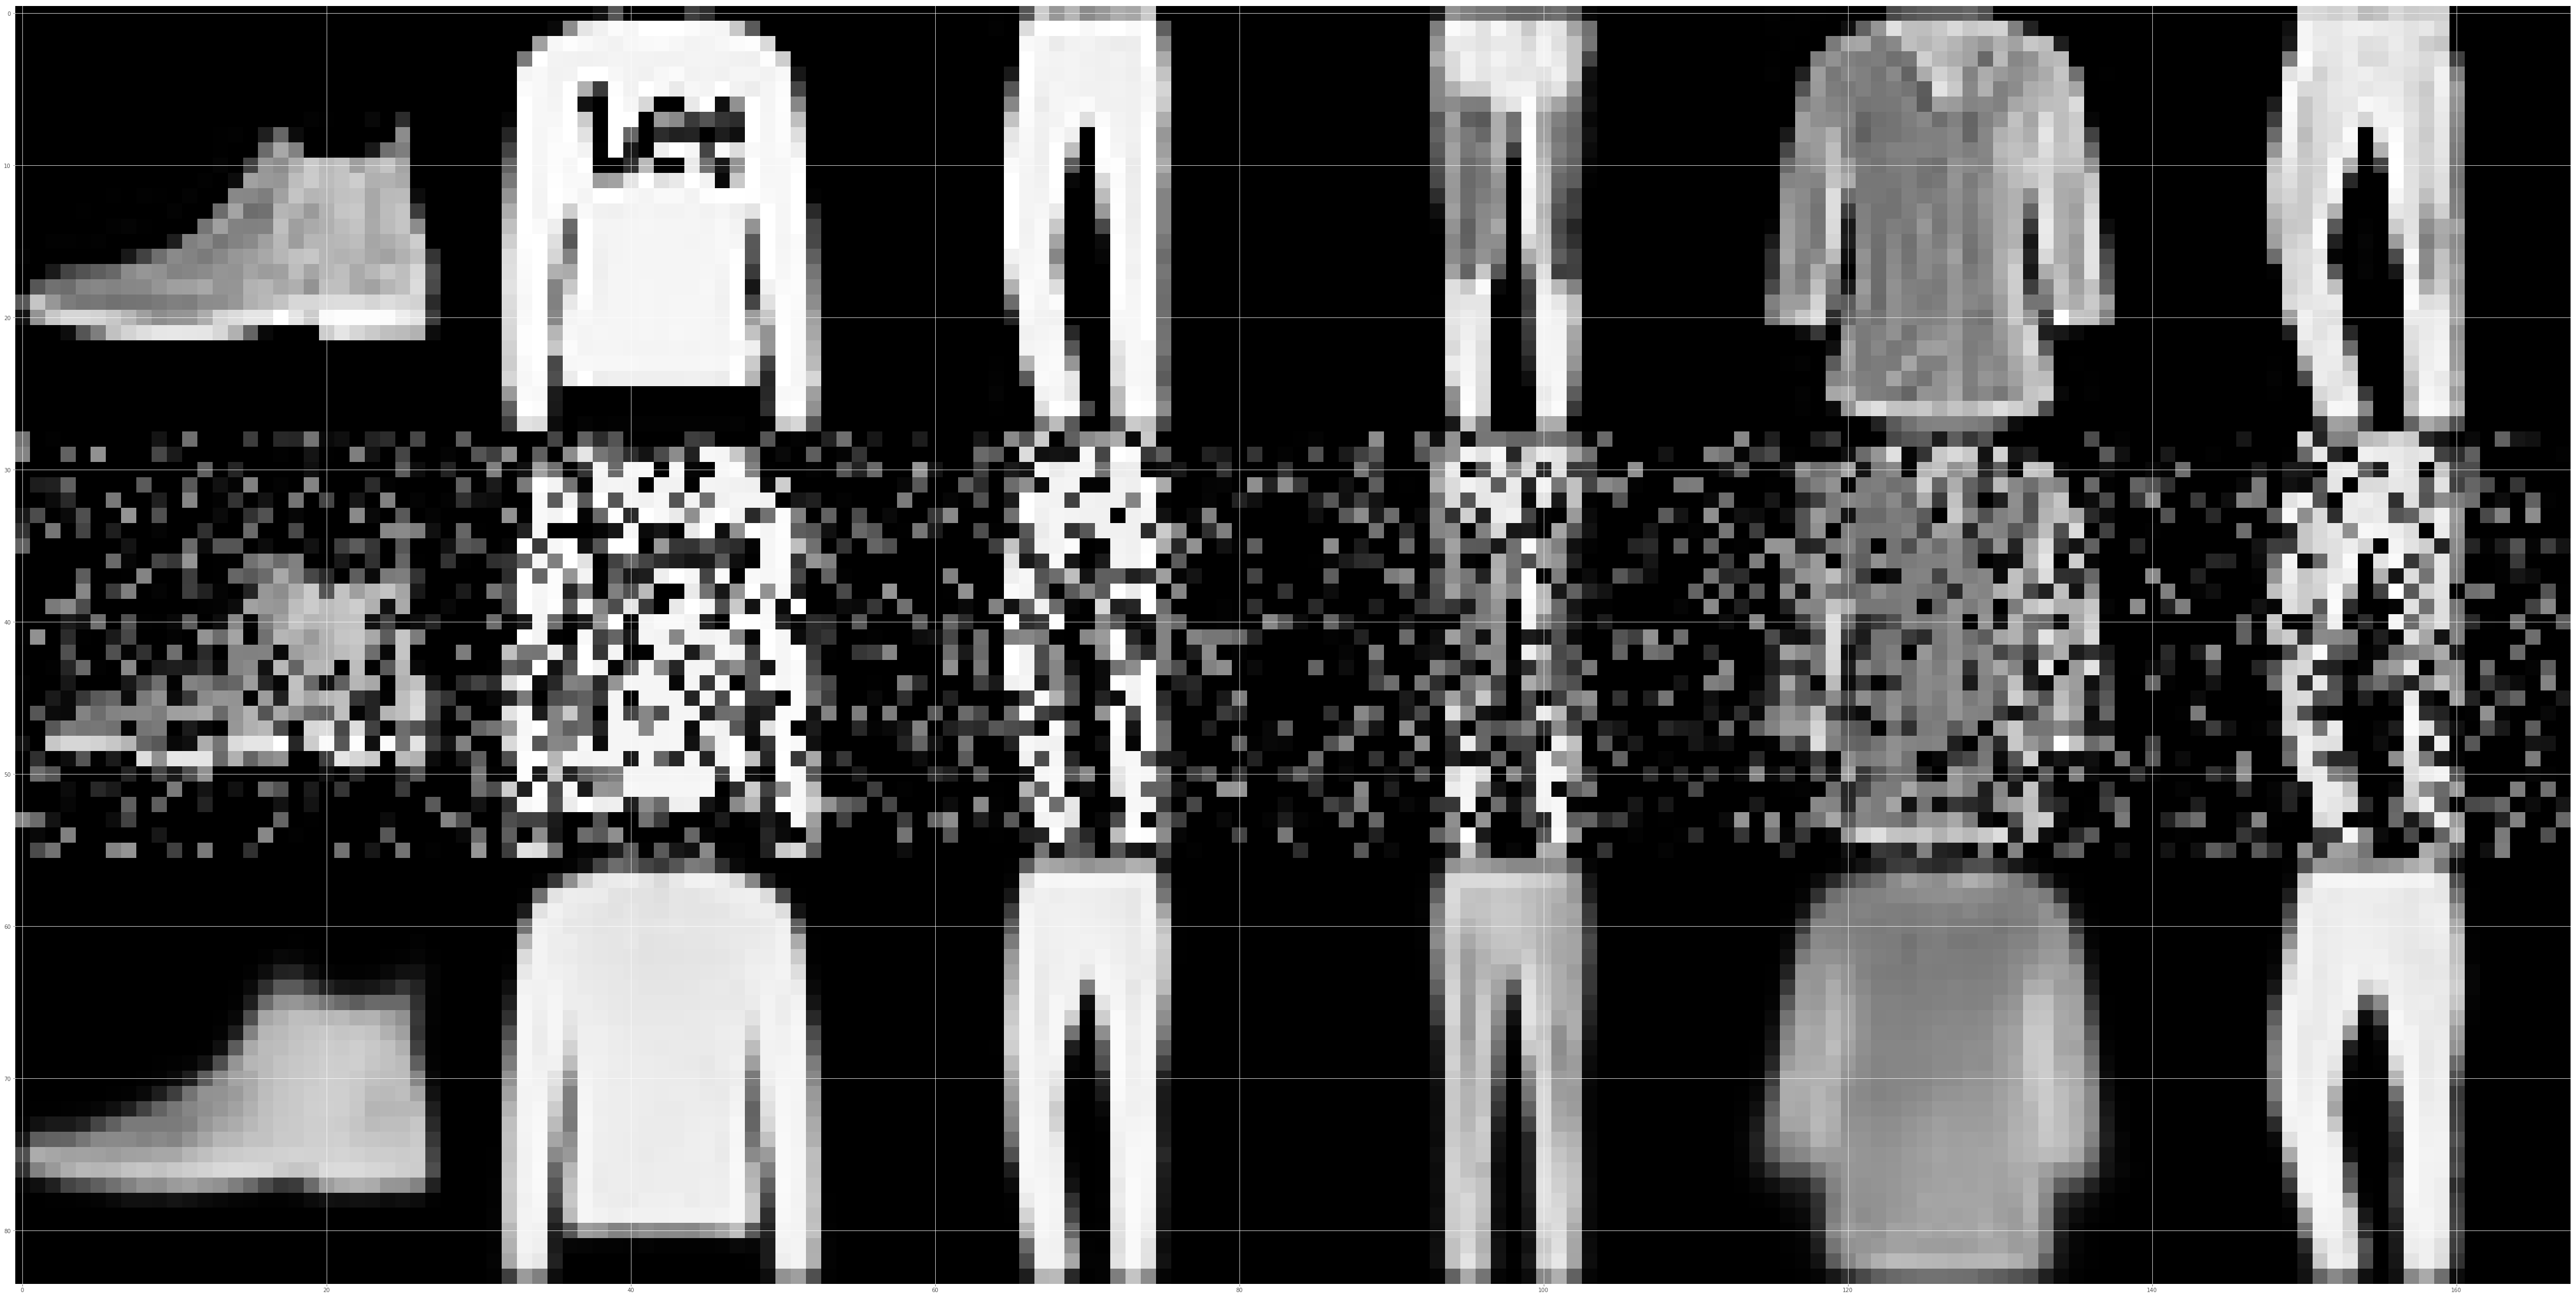

In [19]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Fash-Pim-ParaComparacion.png')
plt.show()